## Import data

In [78]:
from data.data import Unitig, Sequence, Kmer
import pickle
import os
import json
from graph.graph import add_to_dict, get_kmer_count_from_sequences, get_gt_graph, get_unitigs_bcalm, Graph, switch_index
from graph.poa import generate_poa_graph
from data.inout import load_sequences,create_gfa_csv
from common.utils import numseq2bytes, seq2num, compute_unitig_ref
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [79]:
ref_file = "../input/truth_data/GCA_027944875.1_ASM2794487v1_genomic.truth_genes.json"
with open(ref_file, 'r') as f:
    ref_data = json.load(f)
exp = "new_data"
if exp == "real_data":
    read_file = "../input/{}/SRR23044204_1.subset.pandora_gene_calls.json".format(exp)
elif exp=='new_data':
    read_file = "../input/{}/SRR23044204_1.pandora_gene_calls.json".format(exp)

with open(read_file, 'r') as f:
    read_data = json.load(f)

blocks2reads = {}
for k,g in read_data.items():
    for block in g:
        add_to_dict(blocks2reads,block[1:],k)
for k,g in ref_data.items():
    for block in g:
        add_to_dict(blocks2reads,block[1:],k)
blocks = list(blocks2reads.keys())
blocks.sort()

alphabet = [("+"+p1,"-"+p1) for p1 in blocks]
bi_alphabet = (alphabet,{k:((i+1)*((-1)**j)) for i, ks in enumerate(alphabet) for j, k in enumerate(ks)})
l_alphabet = len(alphabet)
if l_alphabet < 2**7:
    Sequence.n_b = 1
elif l_alphabet < 2**15:
    Sequence.n_b = 2
elif l_alphabet < 2**31:
    Sequence.n_b = 4
else:
    Sequence.n_b = 8
Sequence.bi_alphabet = bi_alphabet

ref_seqs = [Sequence(i,numseq2bytes(seq2num(seq,Sequence.bi_alphabet),Sequence.n_b),1) for i,seq in enumerate(ref_data.values())]
read_data_trimmed = read_data.values()
read_seqs = [Sequence(i, numseq2bytes(seq2num(seq,Sequence.bi_alphabet), Sequence.n_b), 1) for i,seq in enumerate(read_data_trimmed)]

with open('reads.npy', 'wb') as f:
    np.save(f,np.array([seq.seq for seq in read_seqs],dtype=object))
b= {}
for i, (p1,p2) in enumerate(alphabet):
    b[i+1]= p1
    b[-(i+1)]=p2
j = json.dumps(b)

with open('blocks.json', 'w') as f:
    f.write(j)

subseq = read_seqs[:]
prev_unitigs = []

n_clip = 5
RES_OUTPUT_FOLDER = "../res/ecoli_bcalm/{}/".format(exp)
kmin, kmax = 2,23
k=kmax
filename = os.path.join(RES_OUTPUT_FOLDER,"res_unitigs_max_unitigs_reads_clippedTEST_k_{}_{}.pkl".format(kmin,kmax))
unitigs = load_sequences(filename)
# unitigs = Graph()
print(len(unitigs))


797


## Compute components

In [80]:
# def add_unitigs_sets(unitigs,sets,key = None):
#     for u in unitigs:
#         if key is None:
#             for key in range(len(sets)):
#                 if u in sets[key]:
#                     sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
#                     sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)
#                     break
#             sets.append(set())
#             key = len(sets)-1
#             sets[key].add(u)
#             sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
#             sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)

#         else:
#             if u not in sets[key]:
#                 sets[key].add(u)
#                 sets = add_unitigs_sets({uu:uu for uu in u.link[0]}, sets, key=key)
#                 sets = add_unitigs_sets({uu:uu for uu in u.link[1]}, sets, key=key)
#     return sets
        


In [81]:
def add_unitigs_sets(unitigs,components,key):
    for u in unitigs:
        if u not in components[key]:
            components[key][u]=u
            components = add_unitigs_sets({uu:uu for uu in u.link[0]}, components, key=key)
            components = add_unitigs_sets({uu:uu for uu in u.link[1]}, components, key=key)
    return components

In [82]:
components = []
for u in unitigs:
    found = False
    for key in range(len(components)):
        if u in components[key]:
            found=True
            break
    if not found:
        components.append(Graph())
        key = len(components)-1
        components[key][u]=u
        components = add_unitigs_sets({uu:uu for uu in u.link[0]}, components, key=key)
        components = add_unitigs_sets({uu:uu for uu in u.link[1]}, components, key=key)

In [83]:
components = [s for s in components if len(s)>1]
components.sort(key = len)

In [84]:
[len(s) for s in components]

[16, 17, 237]

## Compute coordinates in chromosome to construct graph consensus

In [85]:
chromosome = components[-1]

In [86]:
g = get_gt_graph(unitigs)
g.save(os.path.join("graph_on_unitigs.graphml"))
create_gfa_csv("graph_on_unitigs{}",g,k)

In [87]:
g = get_gt_graph(chromosome)
g.save(os.path.join("graph_problem.graphml"))
create_gfa_csv("graph_problem{}",g,k)

In [88]:
len(chromosome)

237

### Check cyclicity

In [89]:
# for u in list(chromosome.keys()):
#     if u.abundance < 4:
#         chromosome.pop(u)
# _ = chromosome.compute_edges(k)

In [90]:
def go_through(seen, rp, n, mode, verbose=False):
    if verbose:
        print(n.id,mode)
    if (n,mode) in rp:
        return True
    if (n,mode) in seen:
        return False
    rp[(n,mode)]=None
    seen[(n,mode)]=None
    for next_n, edge_list in n.link[switch_index(1,mode)].items():
        for edge_mode in edge_list:
            next_mode = mode*edge_mode
            if go_through(seen,rp,next_n, next_mode, verbose=verbose):
                return True
    _ = rp.pop((n,mode))
    return False
def check_cycles(graph, verbose=False):
    seen = {}
    rec_pile = {}
    for u in graph:
        if go_through(seen,rec_pile,u,1, verbose=verbose):
            return True, seen
        if go_through(seen,rec_pile,u,-1, verbose=verbose):
            return True, seen
    return False, seen
cyclic, seen = check_cycles(chromosome, verbose=False)
print(cyclic, len(seen), len(chromosome))


True 108 237


In [91]:
if check_cycles(chromosome, verbose=False)[0]:
    best = max(chromosome, key = len)
    best = chromosome.pop(best)
    n = len(best)
    # split = (n-(k-1))//2
    # print(n,split,split+k)
    # s1 = Sequence(best.id,best.seq[:Sequence.n_b*(split+k-1)], best.abundance)
    # s2 = Sequence(len(unitigs),best.seq[Sequence.n_b*(split):], best.abundance)

    split = n//2
    print(n,split)
    s1 = Sequence(best.id,best.seq[:Sequence.n_b*split], best.abundance)
    s2 = Sequence(len(unitigs),best.seq[Sequence.n_b*split:], best.abundance)
    chromosome[s1]=s1
    chromosome[s2]=s2
    print(s1.id)
    print(s2.id)
    _ = chromosome.compute_edges(k)

445 222
324
797


In [92]:
starts=[]
for u in chromosome:
    l1,l2 = len(u.link[0]) , len(u.link[1])
    if l1*l2==0 and l1+l2!=0:
        starts.append(u)
print(len(starts))

14


In [93]:
print([(i,s.id) for i,l in enumerate(s1.link) for s in l ])
print([(i,s.id) for i,l in enumerate(s2.link) for s in l ])

[(0, 159), (0, 468)]
[(1, 149), (1, 248)]


In [94]:
if not check_cycles(chromosome)[0]:
    starts= [s1,s2]
else:
    raise ValueError

In [95]:
# if len(starts)==0:
#     best = max(chromosome, key = len)
#     starts=[best,best]

In [96]:

if len(starts) ==2:
    start, end = starts[1],starts[0]
else:
    raise ValueError


### Compute consensus with DAG coordinates

In [97]:
def add_coordinate(s, mode, coordinates,c, k):
    # print(s.id)
    if s not in coordinates or c> coordinates[s][0][0]:
        # if all([prev_s in coordinates for prev_s in s.link[switch_index(0,mode)]]) or c==0:
            # if len(s.link[switch_index(0,mode)])==0 or c==0:
            # if c==0:
            #     new_c = 0
            # else:
            #     new_c = max([coordinates[prev_s][0][1] - (k-1) for prev_s in s.link[switch_index(0,mode)]])
            # coordinates[s]=([new_c,new_c+len(s)],mode)
        coordinates[s]=([c,c+len(s)],mode)
        # print(s.id)
        # c = c+1
        # for next_s, edge_modes in s.link[switch_index(0,mode)].items():
        #     for edge_mode in edge_modes:
        #         c = max(c, coordinates[next_s][0]+1)
        # if s.id in [112,132]:
        #     print([coordinates[prev_s][0] for prev_s in s.link[switch_index(0,mode)]])
        #     print(s.id, c, new_c)
        for next_s, edge_modes in s.link[switch_index(1,mode)].items():
            for edge_mode in edge_modes:
                next_mode = mode*edge_mode
                coordinates = add_coordinate(next_s, next_mode, coordinates, c + len(s) - (k-1)+1,k)
            
    return coordinates

coordinates_1 = dict()
coordinates_2 = dict()
s = start
c = 0

coordinates_1 = add_coordinate(start, 1, coordinates_1,0,k)
coordinates_2 = add_coordinate(end, -1, coordinates_2,0,k)

max_1 = max([x[0][1] for x in coordinates_1.values()])
max_2 = max([x[0][1] for x in coordinates_2.values()])

coordinates_2 = {s:([max_2-x[0][1], max_2-x[0][0]],-x[1]) for s,x in coordinates_2.items()}

print(len(coordinates_1),max_1)
print(len(coordinates_2),max_2)

coordinates = dict()

for s in chromosome:
    if s in coordinates_1 and s in coordinates_2:
        coordinates[s] = (np.array(coordinates_1[s][0])+np.array(coordinates_2[s][0]),coordinates_1[s][1])
max_3 = max([coordinates[s][0][1] for s in coordinates])
# for s in chromosome:
#     if coordinates_1[s][0] in [0,67]:
#         print(1,coordinates_1[s][0])
#         print(0,coordinates[s][0])
#         print(str(s))
#     if coordinates_2[s][0] in [0,67]:
#         print(2,coordinates_1[s][0])
#         print(0,coordinates[s][0])
#         print(str(s))
# co2co = list(set([c[0] for c in coordinates.values()]))
# co2co.sort()
# d2co = {e:i for i,e in enumerate(co2co)}
# for s, (c,m) in coordinates.items():
#     coordinates[s] = (d2co[c],m)

230 4189
230 4189


Text(0.5, 1.0, 'Difference of unitig coordinate in the two ways')

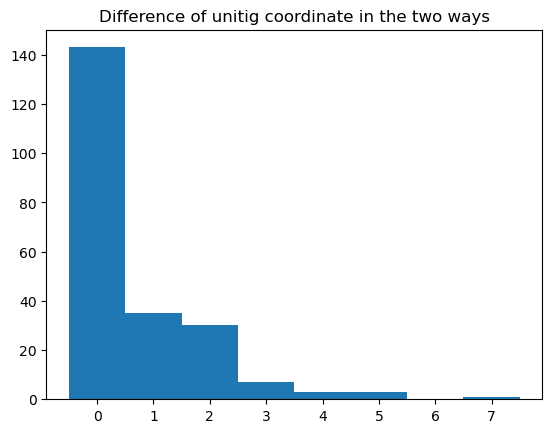

In [98]:
coordinates_diff = {s:coordinates_2[s][0][0]-coordinates_1[s][0][0] for s in coordinates}
plt.hist(coordinates_diff.values(), bins = np.arange(0,max(coordinates_diff.values())+2)-0.5)
plt.title("Difference of unitig coordinate in the two ways")

In [99]:
for u in coordinates:
    u.stability = coordinates_diff[u]
g = get_gt_graph(chromosome)
g.save(os.path.join("graph_stability.graphml"))
for s in coordinates:
    if (coordinates_2[s][0][0]-coordinates_1[s][0][0])>6:
        print(str(s))

In [103]:
import warnings

def sort_by_median(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        m = np.median(np.argwhere(x).flatten())
        if np.isnan(m):
            m=-1
    return m
def get_max_block(x):
    c= 0
    n_c = 0
    new= True
    for xx in x:
        if xx==1:
            if new:
                new=False
            n_c+=1
        else:
            if not new:
                c = max(c,n_c)
                n_c=0
            new = True
    c = max(c,n_c)
    return c
def get_max_block_mean(x):
    c= 0
    n_c = 0
    i_min=0
    n_i_min = 0
    new= True
    for i, xx in enumerate(x):
        if xx==1:
            if new:
                new=False
                n_i_min = i
            n_c+=1
        else:
            if not new:
                if n_c>c:
                    c = n_c
                    i_min = n_i_min
                n_c=0
            new = True
    if n_c>c:
        c = n_c
        i_min = n_i_min
    return i_min+(c-1)/2

(238, 8379)


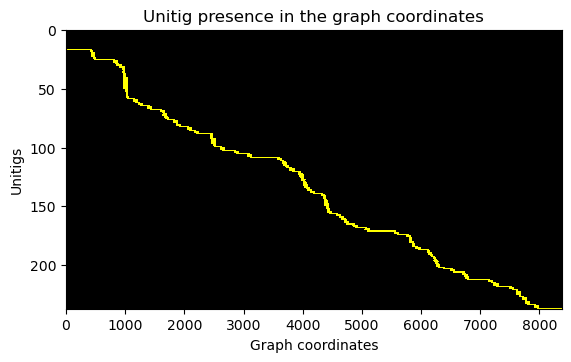

(238, 8378)
(238, 8379)


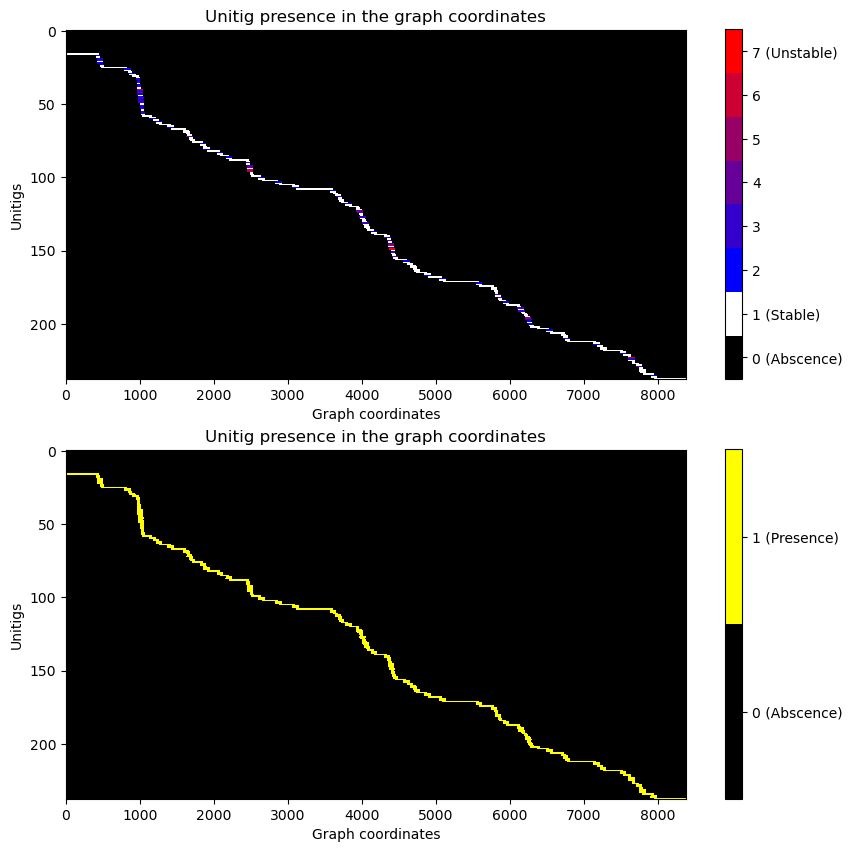

In [150]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

# Define the discrete part of the colormap
discrete_colors = ['black', 'white']

# Define the continuous part of the colormap from blue to red
continuous_cmap = LinearSegmentedColormap.from_list('continuous_cmap', ['blue', 'red'])
continuous_colors = continuous_cmap(np.linspace(0, 1, 6))  # From 2 to 6

# Adding colors for 6 and 7 at the end
end_colors = ['red', 'purple']

# Combine the discrete and continuous colormaps
combined_colors = discrete_colors + continuous_colors.tolist()
combined_cmap = ListedColormap(combined_colors)

# Define the boundaries for the discrete and continuous segments
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]  # Adjust according to your data range
norm = BoundaryNorm(boundaries, combined_cmap.N)

plt.show()
a = np.zeros((len(chromosome),max_3))
print(a.shape)
for  i, s in enumerate(coordinates):
    c = coordinates[s][0]
    a[i,c[0]:c[1]]=coordinates_diff[s]+1
b = list(a)
b.sort(key = sort_by_median)
fig, axs = plt.subplots(2,1,figsize = (10,10))
p = axs[0].imshow(b, cmap = combined_cmap, interpolation='none')
axs[0].set_aspect(a.shape[1]/a.shape[0]*9/16)
axs[0].set_ylabel("Unitigs")
axs[0].set_xlabel("Graph coordinates")
axs[0].set_title("Unitig presence in the graph coordinates")


cbar = fig.colorbar(p, ticks=[1, 2, 3, 4, 5, 6, 7], boundaries=boundaries)

# Adjust colorbar ticks to show labels for discrete and continuous parts
cbar.set_ticks([0,1, 2, 3, 4, 5, 6, 7])
cbar.set_ticklabels(['0 (Abscence)', '1 (Stable)', '2', '3', '4', '5', '6', '7 (Unstable)'])

a = np.zeros((len(chromosome),max_3+1))
print(a.shape)
for  i, s in enumerate(coordinates):
    c = coordinates[s][0]
    a[i,c[0]:c[1]]=1
b = list(a)
b.sort(key = sort_by_median)

# Define the discrete part of the colormap
discrete_colors = ['black', 'yellow']
combined_cmap = ListedColormap(discrete_colors)

# Define the boundaries for the discrete and continuous segments
boundaries = [-0.5, 0.5, 1.5]  # Adjust according to your data range
norm = BoundaryNorm(boundaries, combined_cmap.N)

p = plt.imshow(b, cmap= combined_cmap,interpolation='none')
axs[1].set_aspect(a.shape[1]/a.shape[0]*9/16)
axs[1].set_ylabel("Unitigs")
axs[1].set_xlabel("Graph coordinates")
axs[1].set_title("Unitig presence in the graph coordinates")

cbar = fig.colorbar(p, ticks=[0,1], boundaries=boundaries)

# Adjust colorbar ticks to show labels for discrete and continuous parts
cbar.set_ticks([0,1])
cbar.set_ticklabels(['0 (Abscence)', '1 (Presence)'])

fig.savefig('HM_unitigs.png',dpi = 1000, transparent=True)

In [112]:
consensus_set_coordinates = [set() for _ in range(max_3)]
for s in coordinates:
    c, mode = coordinates[s]
    for i,b in enumerate(s.num(canonical=(mode==1))):
        consensus_set_coordinates[c[0]+2*i].add(b)
        consensus_set_coordinates[c[0]+2*i+1].add(b)

## Compute consensus from local POA

In [ ]:
# sequences = ["abcdef","abcddef"]
# sequences = [[12301,12302,12303,12304,12305,12306,12307,81230],[12301,12302,12302,12303,12304,12305,12306,12307,81230]]
# sequences = [read.num() for read in subseq[:100]]
# # test_order_of_alignment_case1()
# g = generate_poa_graph(sequences)
# # g.generateAlignmentStrings()

In [151]:
# Create topological order from coordinates
topological_order = [d+ (s,) for s,d  in coordinates.items()]
topological_order.sort(key = lambda x: x[0][0])
# for s in chromosome:
#     s.topo_order = -1
for i,s in enumerate(topological_order):
    s[2].topo_order = i

# Compute topological order edges
topo_dict = {s[2]:i for i,s in enumerate(topological_order)}
e_topo = []
for i, (_, mode , s) in enumerate(topological_order):
    for n in s.link[switch_index(1,mode)]:
        e_topo.append([topo_dict[ss] for ss in [s,n] if n in topo_dict])

# Get stables node in the DAG
stables = []
n_nodes = set()
for i, (_, mode , s) in enumerate(topological_order):
    if i in n_nodes:
        n_nodes.remove(i)
    if len(n_nodes) == 0:
        stables.append(i)
    for n in s.link[switch_index(1,mode)]:
        if n in topo_dict:
            n_nodes.add(topo_dict[n])
for s in chromosome:
    s.stability=0
for s in stables:
    topological_order[s][2].stability=1
g = get_gt_graph(chromosome)
g.save(os.path.join("graph_topological_order.graphml"))
create_gfa_csv("graph_topological_order{}",g,k)

In [ ]:
bubbles = [[s[2] for s in topological_order[stables[k]+1:stables[k+1]]] for k in range(len(stables)-1)]
# while True:
#     mode = coordinates[u][1]
#     bubble=[]
#     next = []
#     while True:
#         for uu in u.link[switch_index(1,mode)]:
            
#             print(str(uu), coordinates[uu][1])
#         break
#     break


In [ ]:
def get_all_path(s1,s2, mode, visited, path,res):
    path.append((s1,mode))
    visited.add(s1)
    if s1 == s2:
        res.append(path[::])
    else:
        for n_s1 in s1.link[switch_index(1,mode)]:
            if n_s1 not in visited and n_s1 in coordinates:
                n_mode = coordinates[n_s1][1]
                res = get_all_path(n_s1, s2, n_mode, visited,path,res)
    
    path.pop()
    visited.remove(s1)
    return res
        

In [ ]:
def get_num(s, mode):
    return s.num() if mode==1 else s.num(canonical=False)

In [ ]:
all_path_bubbles = []
for i in range(len(stables)-1):
    s1,s2 = topological_order[stables[i]][2], topological_order[stables[i+1]][2]
    all_path_bubbles.append(get_all_path(s1,s2,coordinates[s1][1],set(),[],[]))
for all_path in all_path_bubbles:
    # print("------new--------")
    for p,path in enumerate(all_path):
        fusion = list(get_num(*path[0])[-(k-1):])
        # print(len(list(get_num(*path[0])[-(k-1):])))
        for i in range(1,len(path)-1):
            fusion = fusion+list(get_num(*path[i])[(k-1):])
            # print(len(list(get_num(*path[i])[(k-1):])))
        all_path[p]=[all_path[p],fusion]
        # print(len(fusion))


------new--------
49
50
51
50
------new--------
44
45
------new--------
44
45
------new--------
50
51
51
52
52
51
53
51
51
49
------new--------
44
43
------new--------
43
44
------new--------
45
44
------new--------
77
78
76
78
79
------new--------
43
44
------new--------
45
44
------new--------
44
45
------new--------
44
45
------new--------
45
46
45
47
46
------new--------
44
45
------new--------
44
45
------new--------
45
44
------new--------
43
44
------new--------
60
59
58
------new--------
43
44
------new--------
87
88
89
88
90
88
89
90
89
87
88
89
88
------new--------
44
45
------new--------
85
86
87
86
87
88
87
86
87
86
------new--------
44
45
------new--------
61
62
62
------new--------
45
44
------new--------
44
45
------new--------
44
45
------new--------
66
65
67
------new--------
43
44
------new--------
49
50
49
------new--------
57
58
58
59
------new--------
22
------new--------
43
44
------new--------
55
54
56
------new--------
45
44
------new--------
45
45
------new----

In [ ]:
# Compute POA and set list consensus in each bubbles and merge theme with stables unitigs
poa_list = []
set_list = [set([c]) for c in get_num(*(topological_order[stables[0]][1:][::-1]))]
for i,bubble in enumerate(all_path_bubbles):
    sequences = [s[1] for s in bubble]
    g = generate_poa_graph(sequences)
    poa_list.append(g)
    # g.generateAlignmentStrings()
    file = "res_all_path"
    if i in [0,3,7,12,17,19,21,23,27,29,30,31,33,35,37,38]:
        file = os.path.join(file,"best_poa_all_path_{}.html".format(i))
    else:
        file = os.path.join(file,"simple_poa_all_path_{}.html".format(i))
    with open(file,"w") as f:
        g.htmlOutput(f)
    l = g.generateAlignment()
    for j,ll in enumerate(l):
        if ll == set([-1570, -542, None]):
            print(i)
    set_list = set_list + l[(k-1):]
    set_list = set_list + [set([c]) for c in get_num(*topological_order[stables[i+1]][1:][::-1])][(k-1):]
print(len(set_list))


19


In [ ]:
g = poa_list[38]
for a in g.generateAlignmentStrings():
    print(a[1])
print(g.generateAlignment())

4072


In [ ]:
# poa_list = []
# for k,bubble in enumerate(bubbles):
#     print(k)
#     sequences = []
#     for unitig in bubble:
#         s = unitig.num() if coordinates[unitig][1]==1 else unitig.num(canonical=False)
#         sequences.append(s) 
#     # test_order_of_alignment_case1()
#     g = generate_poa_graph(sequences)
#     poa_list.append(g)
#     # g.generateAlignmentStrings()
#     with open("poa_{}.html".format(k),"w") as f:
#         g.htmlOutput(f)

## Comparisons of the two consensus

In [ ]:
csl = [len(s) for s in consensus_set]
max_csl = max(csl)+1
csl_count = [csl.count(x) for x in range(max_csl)]

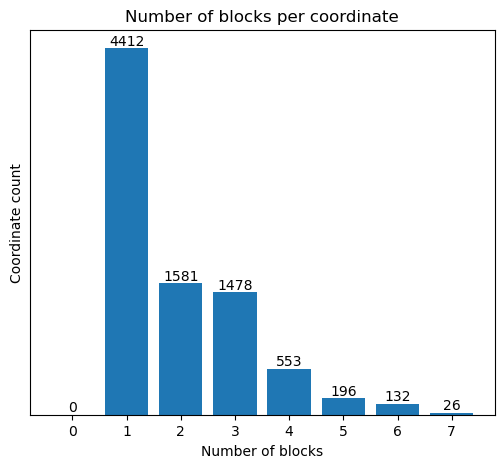

In [119]:
fig, ax = plt.subplots(figsize=(6,5))
p = plt.bar([str(i) for i in range(max_csl)],csl_count,)
for rect in p:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

# plt.yscale("log")
# ax.get_yaxis().set_visible(False)

plt.yticks([])  
ax.set_ylabel("Coordinate count")
ax.set_xlabel("Number of blocks")
ax.set_title("Number of blocks per coordinate")
fig.savefig('n_blocks_coordinate_count.png',dpi = 1000)
# ax.set_xlim()


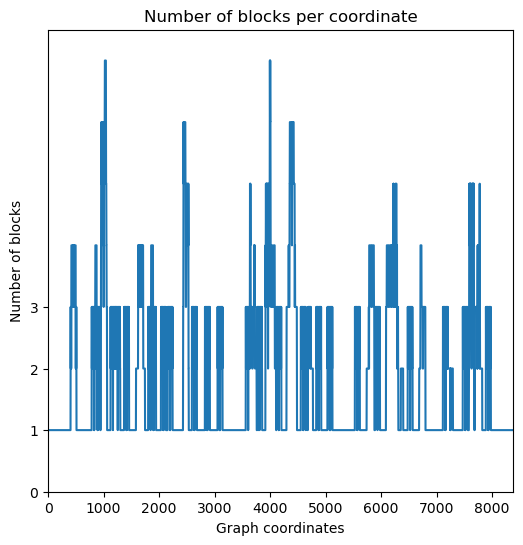

In [120]:
fig, ax = plt.subplots(figsize=(6,6))
p = plt.plot(range(len(csl)),csl)
# ax.set_aspect(len(csl)/max(csl))
ax.set_ylabel("Number of blocks")
ax.set_xlabel("Graph coordinates")
ax.set_title("Number of blocks per coordinate")
ax.set_xlim([0,len(csl)])
ax.set_ylim([0,max_csl-0.5])
# ax.set_yticklabels([0,"",1,"",2,"",3,""])
ax.set_yticks([0,1,2,3])
fig.savefig('n_blocks_coordinate.png',dpi = 1000)

In [141]:
csl = [len(s) for s in set_list]
max_csl = max(csl)+1
csl_count = [csl.count(x) for x in range(max_csl)]

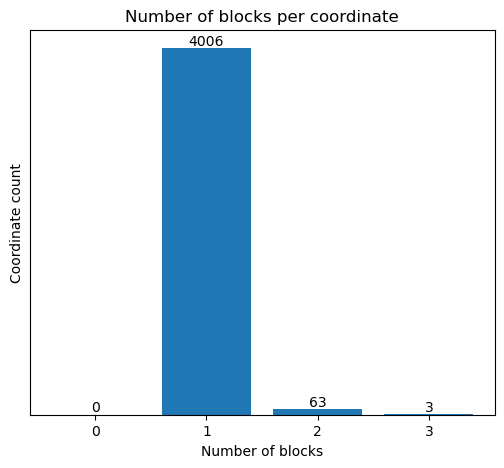

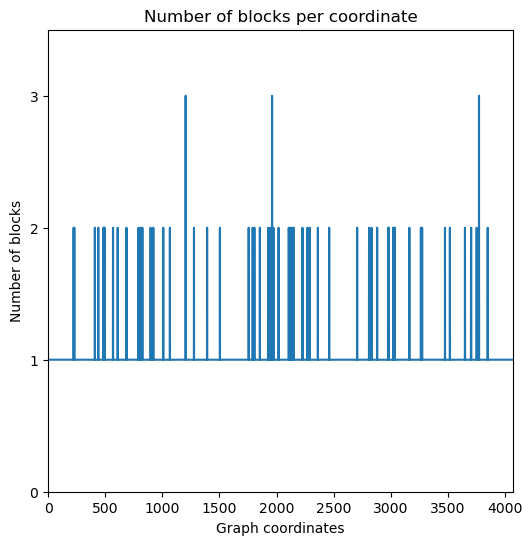

In [142]:
fig, ax = plt.subplots(figsize=(6,5))
p = plt.bar([str(i) for i in range(max_csl)],csl_count,)
for rect in p:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

# plt.yscale("log")
# ax.get_yaxis().set_visible(False)

plt.yticks([])  
ax.set_ylabel("Coordinate count")
ax.set_xlabel("Number of blocks")
ax.set_title("Number of blocks per coordinate")
fig.savefig('n_blocks_coordinate_count.png',dpi = 1000)
# ax.set_xlim()

fig, ax = plt.subplots(figsize=(6,6))
p = plt.plot(range(len(csl)),csl)
# ax.set_aspect(len(csl)/max(csl))
ax.set_ylabel("Number of blocks")
ax.set_xlabel("Graph coordinates")
ax.set_title("Number of blocks per coordinate")
ax.set_xlim([0,len(csl)])
ax.set_ylim([0,max_csl-0.5])
# ax.set_yticklabels([0,"",1,"",2,"",3,""])
ax.set_yticks([0,1,2,3])
fig.savefig('n_blocks_coordinate.png',dpi = 1000)

In [143]:
for i,c in enumerate(csl):
    if c>1:
        print(set_list[i])

{635, None}
{-3687, None}
{None, -2673}
{None, -2673}
{1873, None}
{1571, None}
{-1966, None}
{-1570, None}
{None, -1385}
{2958, None}
{None, 4654}
{None, 542}
{None, -1570}
{2012, None}
{-3629, None}
{-4643, None}
{-1634, None}
{-1967, None}
{-1192, None}
{-1960, -1192, None}
{-1973, None}
{-1859, None}
{635, None}
{None, -1066}
{-1426, None}
{-525, None}
{635, None}
{-992, None}
{-1570, None}
{None, -73}
{920, None}
{-542, -1570, None}
{-717, None}
{-635, None}
{None, -1978}
{1931, None}
{-1413, None}
{-1364, None}
{-1966, None}
{-4654, None}
{2291, None}
{4763, None}
{-4380, None}
{-4372, None}
{635, None}
{4654, None}
{None, -1570}
{3142, None}
{2809, None}
{1570, None}
{-1978, None}
{1973, None}
{2809, None}
{805, None}
{4195, None}
{-2860, None}
{1865, None}
{-3288, -3291}
{1570, None}
{2080, None}
{2080, None}
{2080, None}
{-1955, None}
{-2003, None}
{-3631, None, -2010}
{-1570, None}


## Align read on consensus

In [77]:
read_sets_cano = [set(read.num()) for read in read_seqs]
read_sets_ncano = [set(read.num(canonical=False)) for read in read_seqs]
consensus_reads = np.zeros((len(read_seqs),max_3))

for i, (rs, rsn) in enumerate(zip(read_sets_cano,read_sets_ncano)):
    a = np.zeros(max_3)
    an = np.zeros(max_3)
    a = [len(cs.intersection(rs))>0 for cs in consensus_set]
    an = [len(cs.intersection(rsn))>0 for cs in consensus_set]
    af = max(a,an,key= sum)
    consensus_reads[i] = af

NameError: name 'consensus_set' is not defined

In [43]:
consensus_reads_l = list(consensus_reads)
consensus_reads_l.sort(key = sort_by_median)
fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l, interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0])
fig.savefig('HM_reads.png',dpi = 500)
consensus_reads_l_block = list(consensus_reads)
consensus_reads_l_block.sort(key = get_max_block_mean)fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l_block, cmap="gnuplot",interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0]*9/16)
ax.set_xlabel("Graph coordinates")
ax.set_ylabel("Reads")
ax.set_title("Matrix of read presence")
fig.savefig('HM_reads_block.png',dpi = 1000, transparent=True)


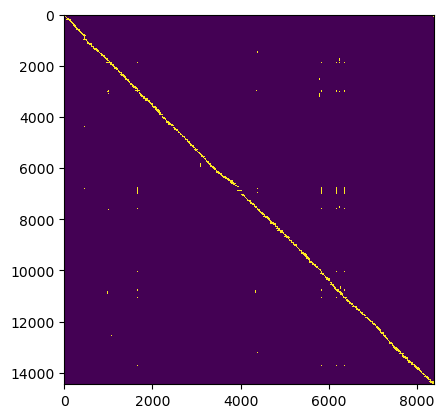

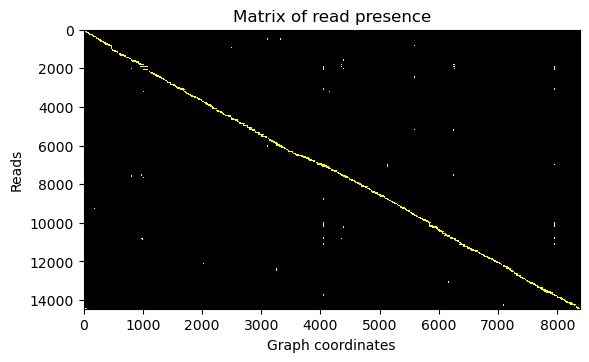

In [47]:
ratio_total = [sum(consensus_reads[i])/2/len(s) for i, s in enumerate(read_seqs)]
ratio_max_block = [get_max_block(consensus_reads[i])//2/len(s) for i, s in enumerate(read_seqs)]

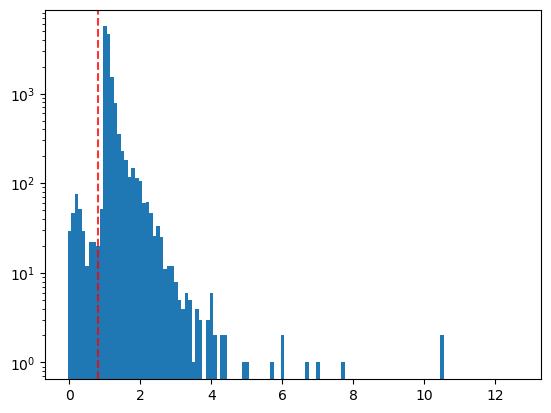

In [48]:
_ = plt.hist(ratio_total,bins = np.arange(min(ratio_total)-0.05,max(ratio_total)-0.05,0.1))
plt.yscale("log")
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax)
plt.vlines(0.8,ymin,ymax, color = 'red',  alpha = 0.8,  linestyle = '--')

In [49]:
a = compute_unitig_ref(read_seqs,ref_seqs)
a_a = np.array(a[1])
a_l = list(a_a.argmax(axis=0))
a_n = [a_l.count(k) for k in range(3)]

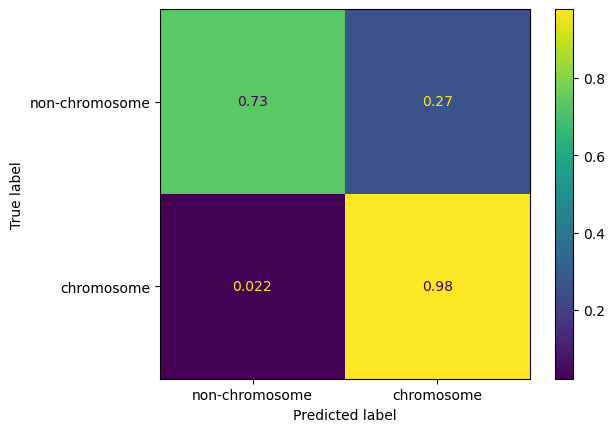

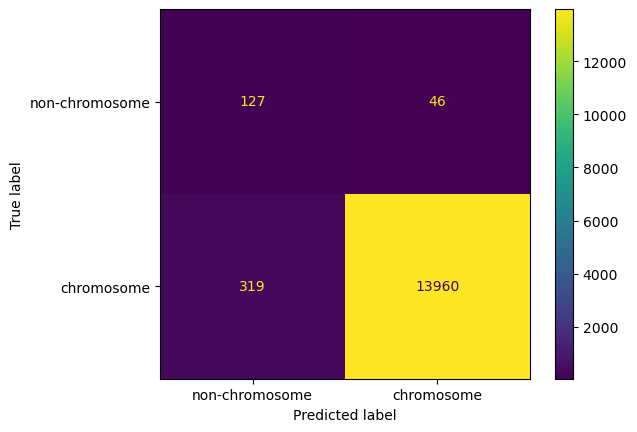

In [50]:
y_total = np.array(ratio_total)>=1
y_ref = np.array(a_l)<1
cm = confusion_matrix(y_ref,y_total,normalize='true')
cm_display = ConfusionMatrixDisplay(cm, display_labels=[ "non-chromosome","chromosome"])
cm_display.plot()
cm = confusion_matrix(y_ref,y_total)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[ "non-chromosome","chromosome"])
cm_display.plot()

In [51]:
[sum(ref_seqs[0].num(canonical=False)==x) for x in [ 1230, -1081,  1324, -1358, -1360,  1380,  1147]]

[0, 0, 0, 1, 0, 0, 0]

In [52]:
print(ratio_total[np.argmax(ratio_total)],read_seqs[np.argmax(ratio_total)].num())
print(ratio_max_block[np.argmax(ratio_max_block)],read_seqs[np.argmax(ratio_max_block)].num())


12.75 [-1722  1570]
6.0 [1061]


In [53]:
read_seqs[1898].num()

array([-3676,  3677, -3675,  3673,  3672,  3674,  -312,  -311,  4055,
        1914, -3858, -3449, -3448, -3447, -3446, -1479, -3445, -3444,
        3450, -3170,  3171,   641,   640,   639,  3030, -2999, -2998,
       -2997, -2996,   545,  4687,  4062,   943], dtype=int16)

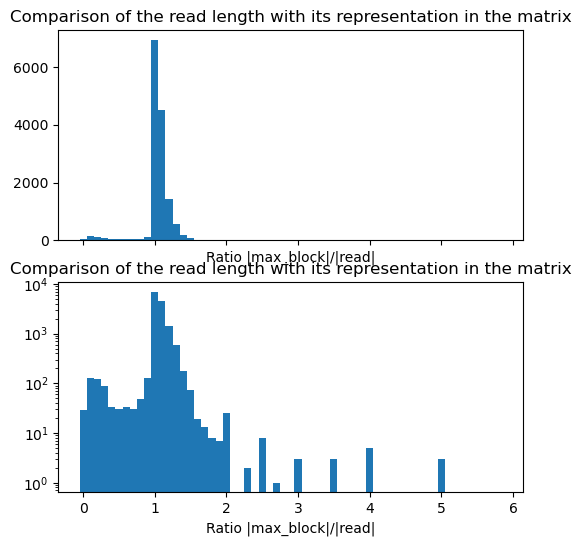

In [54]:
fig, axs = plt.subplots(2,1,figsize=(6,6),sharex=True)
p = axs[0].hist(ratio_max_block,bins = np.arange(min(ratio_max_block)-0.05,max(ratio_max_block)-0.05,0.1))
axs[0].set_xlabel("Ratio |max_block|/|read|")
axs[0].set_title("Comparison of the read length with its representation in the matrix")
p = axs[1].hist(ratio_max_block,bins = np.arange(min(ratio_max_block)-0.05,max(ratio_max_block)-0.05,0.1))
axs[1].set_xlabel("Ratio |max_block|/|read|")
axs[1].set_title("Comparison of the read length with its representation in the matrix")
axs[1].set_yscale('log')
fig.savefig('ratio_block_read.png',dpi = 1000)

In [55]:
len(a_l)

14452

In [56]:
len(ratio_max_block)

14452

In [57]:
from collections import Counter

Counter(a_l)

Counter({0: 14279, 1: 134, 2: 39})

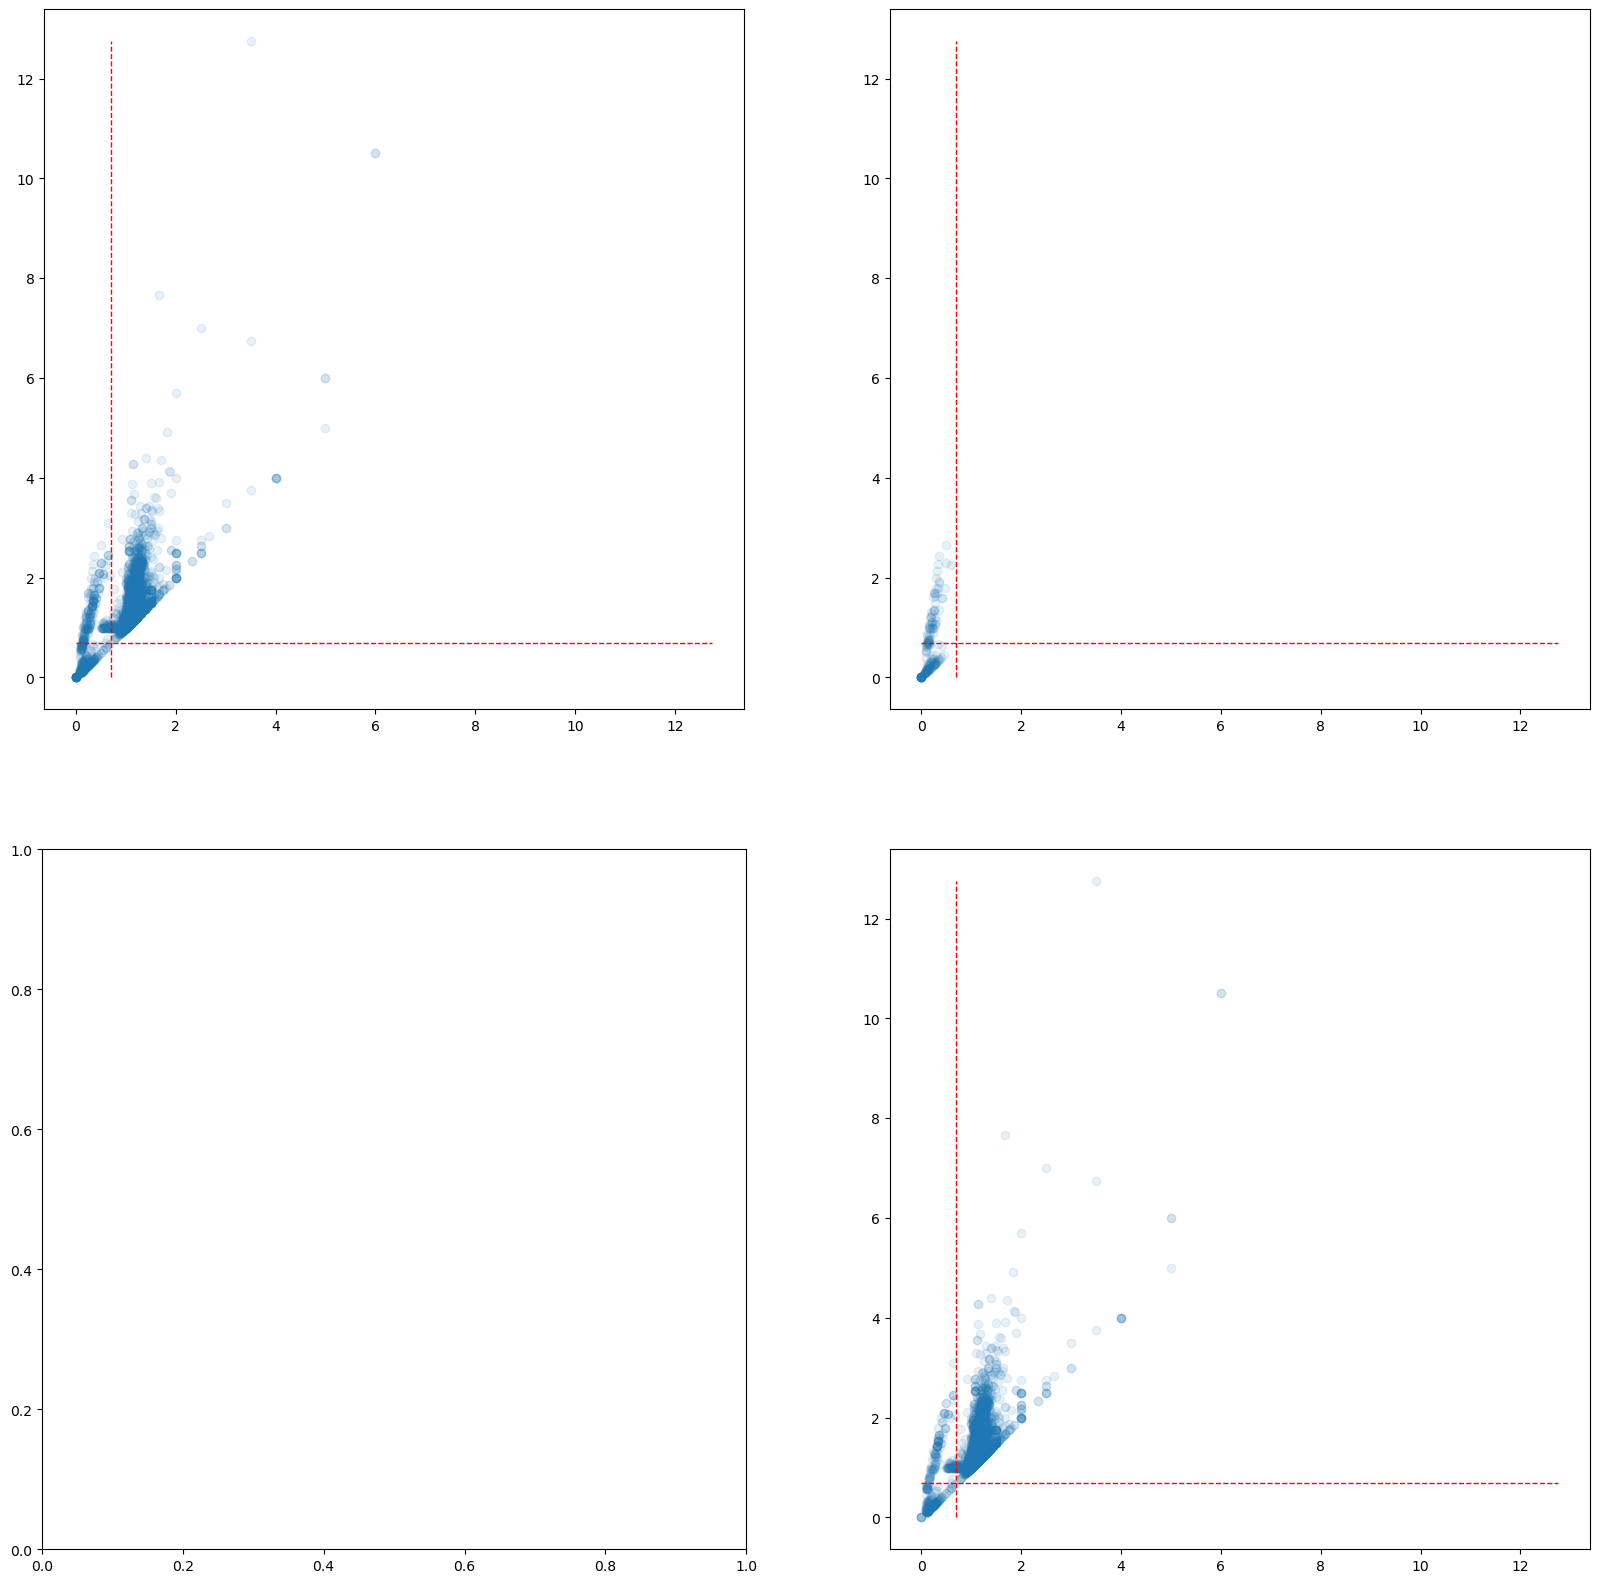

In [58]:
fig, axs = plt.subplots(2,2,figsize = (20,20))
axs[0,0].scatter(ratio_max_block, ratio_total, alpha =0.1)
ma = max(max(ratio_max_block),max(ratio_total))
axs[0,0].plot([0.7,0.7], [0,ma],"r--", linewidth = 1)
axs[0,0].plot([0,ma],[0.7,0.7], "r--", linewidth = 1)
axs[0,0].set_aspect("equal")


axs[0,1].scatter(np.array(ratio_max_block)[np.array(a_l)>0], np.array(ratio_total)[np.array(a_l)>0], alpha =0.1)
axs[0,1].set_xlim(axs[0,0].get_xlim())
axs[0,1].set_ylim(axs[0,0].get_ylim())
axs[0,1].plot([0.7,0.7], [0,ma],"r--", linewidth = 1)
axs[0,1].plot([0,ma],[0.7,0.7], "r--", linewidth = 1)
axs[0,1].set_aspect("equal")

axs[1,1].scatter(np.array(ratio_max_block)[np.array(a_l)==0], np.array(ratio_total)[np.array(a_l)==0], alpha =0.1)
axs[1,1].set_xlim(axs[0,0].get_xlim())
axs[1,1].set_ylim(axs[0,0].get_ylim())
axs[1,1].plot([0.7,0.7], [0,ma],"r--", linewidth = 1)
axs[1,1].plot([0,ma],[0.7,0.7], "r--", linewidth = 1)
axs[1,1].set_aspect("equal")





np.array(ratio_total)>=1
y_ref = np.array(a_l)


In [59]:
ma

12.75

In [60]:
y_block = np.array(ratio_max_block)>0.5
y_ref = np.array(a_l)<1

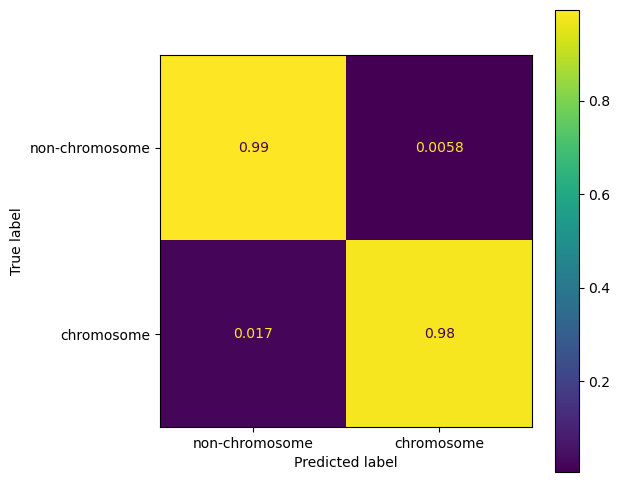

In [61]:
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_ref,y_block,normalize='true')
cm_display = ConfusionMatrixDisplay(cm, display_labels=["non-chromosome", "chromosome"])
cm_display.plot(ax=ax)
fig.savefig('cm_scaled.png',dpi = 1000)

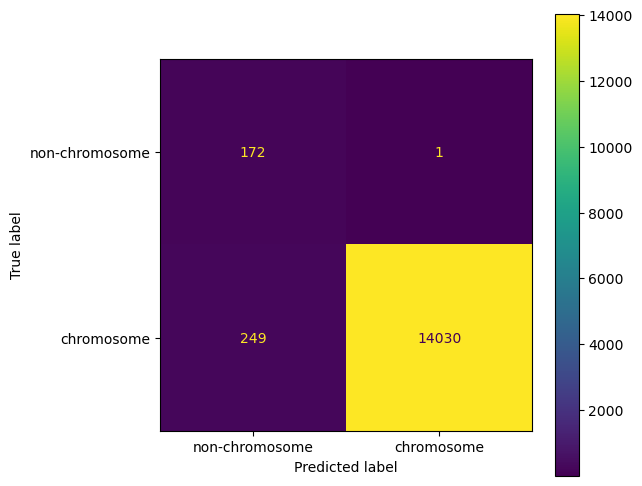

In [62]:
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_ref,y_block)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[ "non-chromosome","chromosome"])
cm_display.plot(ax=ax)
fig.savefig('cm_nscaled.png',dpi = 1000)

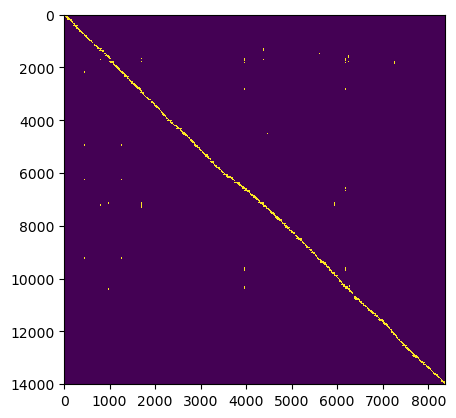

In [63]:
consensus_reads_l = list(consensus_reads[y_total])
consensus_reads_l.sort(key = get_max_block_mean)

fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l, interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0])
fig.savefig('HM_unitigs_block.png',dpi = 500)

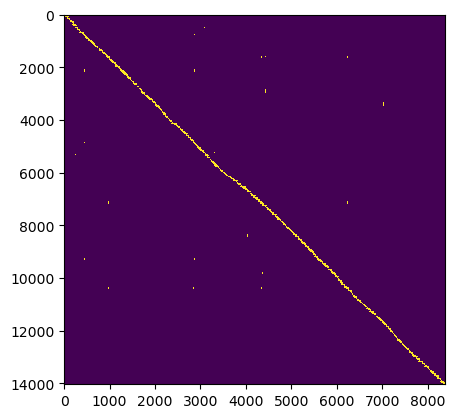

In [64]:
consensus_reads_l_block = list(consensus_reads[y_block])
consensus_reads_l_block.sort(key = get_max_block_mean)

fig, ax = plt.subplots()
p = plt.imshow(consensus_reads_l_block, interpolation='none')
ax.set_aspect(consensus_reads.shape[1]/consensus_reads.shape[0])
fig.savefig('HM_unitigs_block.png',dpi = 500)

In [65]:
ref = ref_seqs[0].num(canonical=False)
# m = np.zeros((),))
x,y = [],[]
for i in range(len(ref_seqs[0])):
    for j in range(len(consensus_set)):
        if ref[i] in consensus_set[j]:
            x.append(i)
            y.append(j)

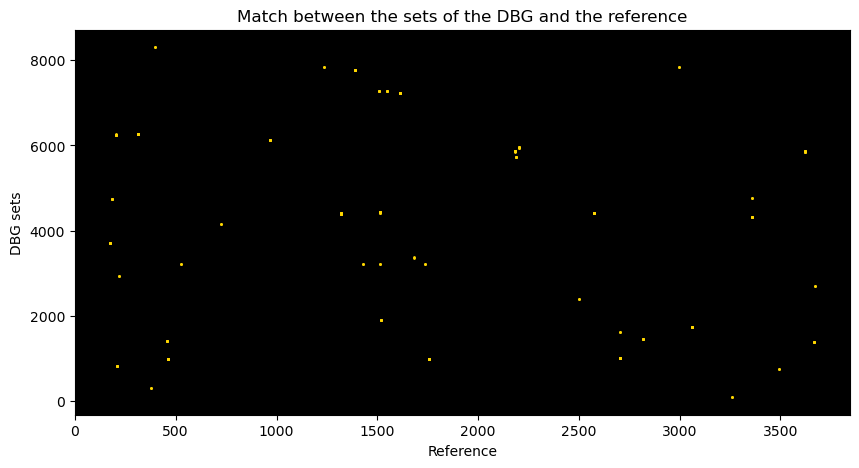

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("Reference")
ax.set_ylabel("DBG sets")
ax.set_title("Match between the sets of the DBG and the reference")
ax.set_facecolor("Black")
plt.scatter(x,y, s=1, c="gold", )

In [67]:
ref = ref_seqs[0].num(canonical=False)
# m = np.zeros((),))
x,y = [],[]
for i in range(len(ref)):
    for j in range(len(ref)):
        if ref[i] == ref[j]:
            x.append(i)
            y.append(j)

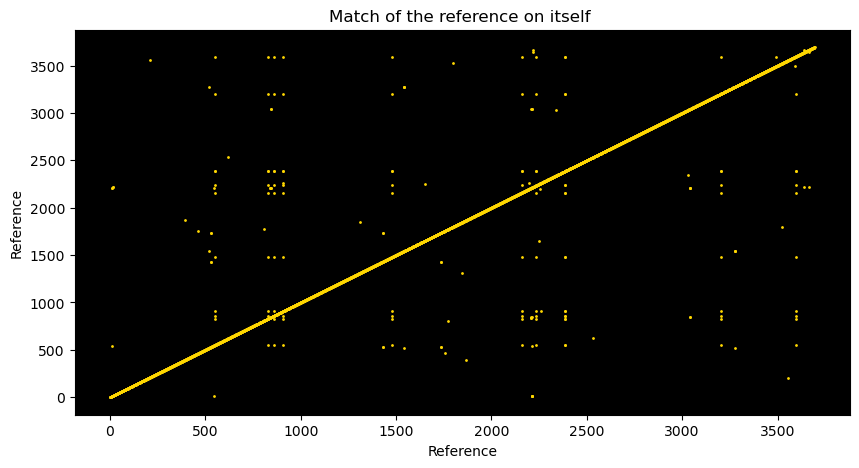

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel("Reference")
ax.set_ylabel("Reference")
ax.set_title("Match of the reference on itself ")
ax.set_facecolor("Black")
plt.scatter(x,y, s=1, c="gold", )

In [39]:
a= [[] for _ in range(max([x[0] for x in coordinates.values()])+1)]
for u, c in coordinates.items():
    a[c[0]].append((u,str(u)))
for k,l in enumerate(a):
    for i,s in l:
        if s=="+rhsA.rhsB.rshA~~~+group_4333~~~+group_4643~~~-group_5018~~~-group_5020~~~+rhsA.rhsB.rshA~~~+group_4446~~~+group_4445~~~-yibH~~~-yibI~~~+mtlA~~~+mtlD~~~+mtlR~~~+yibL~~~+lldP~~~+lldR~~~+lldD~~~+trmL~~~-cysE~~~-gpsA~~~-secB~~~-grxC~~~-yibN~~~+gpmM~~~+envC~~~+yibQ~~~-waaH~~~-tdh~~~-kbl~~~+rfaD~~~+rfaF~~~+rfaC~~~+group_2413~~~-group_2414~~~-waaZ~~~-rfaY~~~-group_4451~~~-waaB~~~-group_2415~~~-rfaP~~~-rfaG~~~+waaA~~~+coaD~~~-mutM~~~-group_4343~~~+coaBC~~~+dut~~~+slmA~~~-pyrE~~~-rph~~~+yicC~~~+group_4998~~~+dinD~~~+yicG~~~-ligB~~~+gmk~~~+rpoZ~~~+spoT~~~+trmH~~~+recG~~~-gltS~~~+xanP~~~+yicH~~~-yicI~~~-group_4347~~~+setC~~~+yicL~~~-nlpA~~~+yicS~~~-nepI~~~-yicN~~~-adeQ~~~+adeD~~~-Escherichia_coli_UhpT3003890HG7388671293426629356583667.uhpT~~~-group_380~~~-uhpB~~~-uhpA3003893HG7388671293070729312983668.uhpA~~~-ilvN~~~-group_381~~~+group_4998~~~+emrD~~~-aslB~~~-yidG~~~-yidH~~~+yidI~~~-aslA.yidJ~~~-yidK~~~+yidL~~~-glvG.celF~~~-glvB~~~+yidP~~~-yidE~~~-ibpB~~~-ibpA~~~+yidQ~~~-yidR~~~+cbrA~~~-dgoT.uhpC~~~-dgoD~~~-dgoA~~~-dgoK~~~-dgoR~~~+yidX~~~-yidA~~~-yidB~~~-gyrB3003303AP0090481376029537627102063.gyrB~~~-recF~~~-dnaN~~~+rnpA~~~+yidC":
            print(k)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
l = [len(aa) for aa in a]

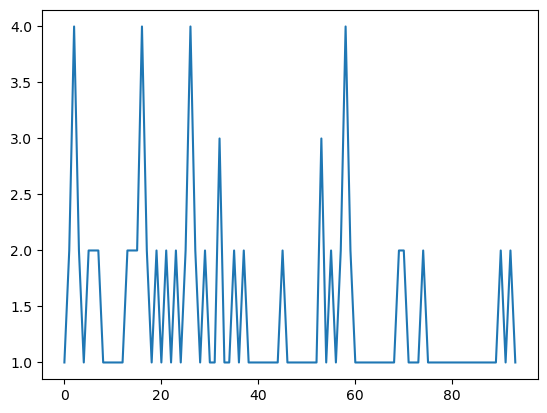

In [ ]:
plt.plot([len(aa) for aa in a])

In [ ]:
np.argmax([np.array([len(s) for s,_ in aa]).std() for aa in a])

74

In [ ]:
for aa in a[74]:
    print(str(aa[0]))

-yraJ~~~-yraI~~~-yraH~~~-agaD~~~-agaC~~~+group_5020~~~+group_5018~~~-agaC~~~-agaB~~~-kbaY~~~-agaS~~~-group_4546~~~-agaF~~~-agaE~~~-agaW~~~-agaV~~~+agaR~~~-yhaV~~~-prlF~~~-garD~~~+garP~~~+garL~~~+garR~~~+garK~~~-yhaC~~~-yhaB~~~-tdcR~~~+tdcA~~~+tdcB
+mtr~~~-yhbW~~~-rlhA~~~-ubiU~~~+yhbS~~~-yhbQ~~~+yhbP~~~-yhbO~~~+yraR~~~+yraQ~~~-dolP~~~-yraN~~~-lpoA~~~+rsmI~~~-yraK~~~-yraJ~~~-yraI~~~-yraH~~~-agaD~~~-agaC~~~+group_5020~~~+group_5018~~~-agaB~~~-kbaY~~~-agaS~~~-group_4546~~~-agaF~~~-agaE~~~-agaW~~~-agaV~~~+agaR~~~-yhaV~~~-prlF~~~-garD~~~+garP~~~+garL~~~+garR~~~+garK~~~-yhaC~~~-yhaB~~~-tdcR~~~+tdcA~~~+tdcB~~~+tdcC


In [ ]:
strs = [ "-group_5074~~~-chaA~~~+chaC~~~-ychN~~~+ychO~~~-narX~~~-group_45~~~+narK~~~+narZ~~~+narH~~~+narJ~~~+narI~~~-purU~~~+rssA~~~+rssB~~~+galU~~~-HNS3000676BA0000073173769017381045476.hns~~~+tdk~~~-group_4316~~~-adhE~~~-group_4280~~~+oppA~~~+oppB~~~+oppC~~~+oppD~~~+oppF~~~-cls~~~-clsA~~~-yciI~~~+tonB~~~-yciA~~~-yciB~~~-yciC~~~+ompW~~~-yciE~~~-yciF~~~-trpA~~~-trpB~~~-trpF~~~-trpD~~~-trpE~~~+yciV~~~+yciO~~~+group_4480~~~+rluB~~~-cobO~~~-yciK~~~-yciN~~~+topA~~~+cysB~~~+group_5020~~~+group_5018",
         "-oppA~~~+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~+group_5074",
         "+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ",
         "+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~+group_5074~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ",
         "+group_5074~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ~~~+ldcA",
         "-oppA~~~+group_4280~~~+adhE~~~+group_4316~~~-tdk~~~+HNS3000676BA0000073173769017381045476.hns~~~-galU~~~-rssB~~~-rssA~~~+purU~~~-narI~~~-narJ~~~-narH~~~-narZ~~~-narK~~~+group_45~~~+narX~~~-ychO~~~+ychN~~~-chaC~~~+chaA~~~+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ~~~+ldcA",
         "+group_5074~~~-kdsA~~~-sirB1~~~-sirB2~~~-prmC~~~-prfA~~~-hemA~~~+lolB~~~+ispE~~~+prs~~~+dauA~~~-ychH~~~+ychF~~~-group_4450~~~+ycgV~~~-dhaR~~~+dhaK~~~+dhaL~~~+dhaM~~~+treA~~~-yeaQ~~~+ldcA~~~+nhaP2~~~-dadX~~~-dadA~~~+ycgB~~~-fadR~~~+nhaB~~~+dsbB~~~-umuC~~~-umuD~~~+hlyE~~~-ycgN~~~-ycgM~~~-ycgL~~~+group_43~~~-ycgJ~~~+minC~~~+minD~~~+minE~~~-aidA.ypjA~~~+ymgG~~~+ymgD~~~-aidA~~~-group_4289~~~-pdeG~~~-ymgB~~~+bluF~~~+ycgX~~~-icd~~~+rluE~~~+nudJ~~~+mnmA~~~+purB~~~+Klebsiella_mutant_PhoP3003585FO8349061232563623263084715.phoP~~~+phoQ~~~+roxA~~~-pepT~~~+potA~~~+potB~~~-tfaX~~~+group_5108~~~-group_4703~~~+tnp.orfA~~~+tnp.tra5~~~+group_5066~~~-group_4703~~~-lomR~~~-group_4837~~~-rri1~~~-gp18~~~-group_4932~~~-group_4933~~~-group_4934~~~-group_4935~~~-group_4936~~~-group_4937~~~-group_4938~~~-group_4939~~~-group_4940~~~-group_4941~~~-group_4942~~~-group_4943~~~-group_4944~~~+iss~~~-rrrD.rrrQ~~~-group_5175~~~-essD~~~-group_4610~~~+iraM~~~-group_5076~~~-group_5247~~~-group_1886~~~-group_5161~~~-group_5243~~~+group_1061~~~+group_1899~~~+group_4383~~~+group_1900~~~+potC~~~+potD~~~+group_4458~~~+ycfZ~~~-cobB~~~-nagK~~~-lolE~~~-lolD~~~-lolC~~~+ycfT~~~+mfd~~~+ycfS~~~-bhsA~~~+comR~~~-ndh~~~-ycfP~~~-lpoB~~~-group_36~~~+fhuE~~~-ptsG~~~-ycfH~~~-holB~~~-tmk~~~-yceG~~~-pabC~~~-fabD~~~-fabH~~~-plsX~~~-yceD~~~+yceF~~~-rluC~~~+group_5020~~~+group_5018",
]
for k,c in enumerate([coordinates,coordinates_1,coordinates_2]):
    for aa in c:
        for i, s in enumerate(strs):
            if str(aa) == s:
                print(i,aa.id,k,c[aa][0])

0 112 0 34
1 113 0 33
3 39 0 32
4 176 0 31
2 208 0 32
6 132 0 30
5 435 0 32
6 132 1 27
4 176 1 28
3 39 1 29
2 208 1 29
1 113 1 30
5 435 1 28
0 112 1 31
0 112 2 30
1 113 2 29
3 39 2 28
2 208 2 28
4 176 2 27
5 435 2 29
6 132 2 26


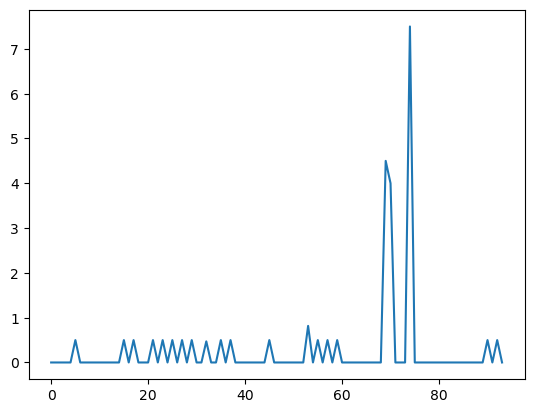

In [ ]:
plt.plot([np.array([len(s) for s,_ in aa]).std() for aa in a])

In [4]:
read_file = "../input/real_data/SRR23044204_1.subset.pandora_gene_calls.json"
read_file = "../input/new_data/SRR23044204_1.pandora_gene_calls.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
read_pos_file = "../input/real_data/SRR23044204_1.subset.pandora_gene_positions.json"
read_pos_file = "../input/new_data/SRR23044204_1.pandora_gene_positions.json"
with open(read_pos_file, 'r') as f:
    gene_positions_reads = json.load(f)

d = [len(r)-len(r2) for r,r2 in  zip(read_data.values(),gene_positions_reads.values())]
print(sum([len(r) for r in read_data.values()]))
print(sum([len(r) for r in gene_positions_reads.values()]))

380533
380533


In [5]:
len(read_data)

14452

In [15]:
d = {}
l=[]
for r, p in zip(read_data.values(), gene_positions_reads.values()):
    for b, bp in zip(r,p):
        b = b[1:]
        if b not in d:
            d[b]=[]
        d[b].append(bp[1]-bp[0])
        l.append(bp[1]-bp[0])

In [16]:
l_mean =[]
for b in d.values():
    l_mean.append((np.mean(b),len(b)))
ll = []
for a,b in l_mean:
    ll+=([a]*b)

(array([   0.,    0.,    0.,    0.,    0.,    0.,  860.,    0.,    0.,
           0.,    0.,    0.,    0.,  335.,  430.,   95.,    0.,    0.,
         133.,    0.,    0.,  343.,  690., 1017., 3678., 3623., 2579.,
        3438., 2435., 3779., 2758., 3502., 3244., 2247., 2555., 2701.,
        2716., 3572., 3052., 3057., 2308., 2484., 3595., 3256., 2734.,
        4209., 3553., 2063., 2327., 2623., 3448., 2523., 2971., 2451.,
        3585., 3032., 2786., 2730., 3696., 2695., 2760., 3997., 2980.,
        3163., 3367., 3179., 3948., 2447., 4010., 2598., 3386., 4736.,
        3950., 3483., 2852., 2211., 3153., 3344., 3913., 2646., 1621.,
        2653., 2858., 3251., 3208., 2323., 4522., 2929., 3751., 3959.,
        2611., 2824., 3218., 2524., 3141., 2282., 3606., 2920., 2475.,
        2687., 2643., 2720., 2945., 1801., 2030., 2092., 1476., 2504.,
        2999., 1770., 1777., 1977., 2346., 2631., 2417., 1608., 1650.,
        2542., 2616., 2180., 2243., 1618., 2097., 2143., 1552., 1969.,
      

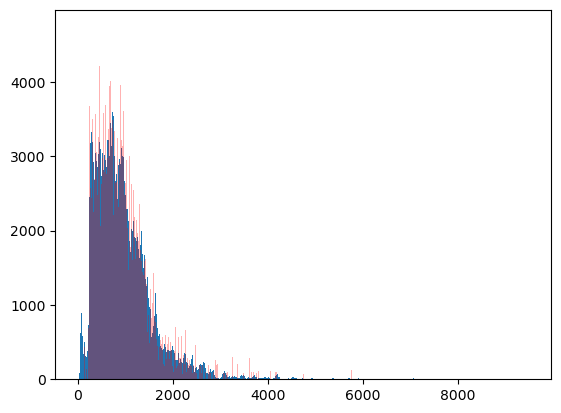

In [8]:
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
ax1.hist(l,bins=range(0,max(l)+10,10))
ax1.hist(ll,bins=range(0,max(l)+10,10),color="red", alpha=0.3)


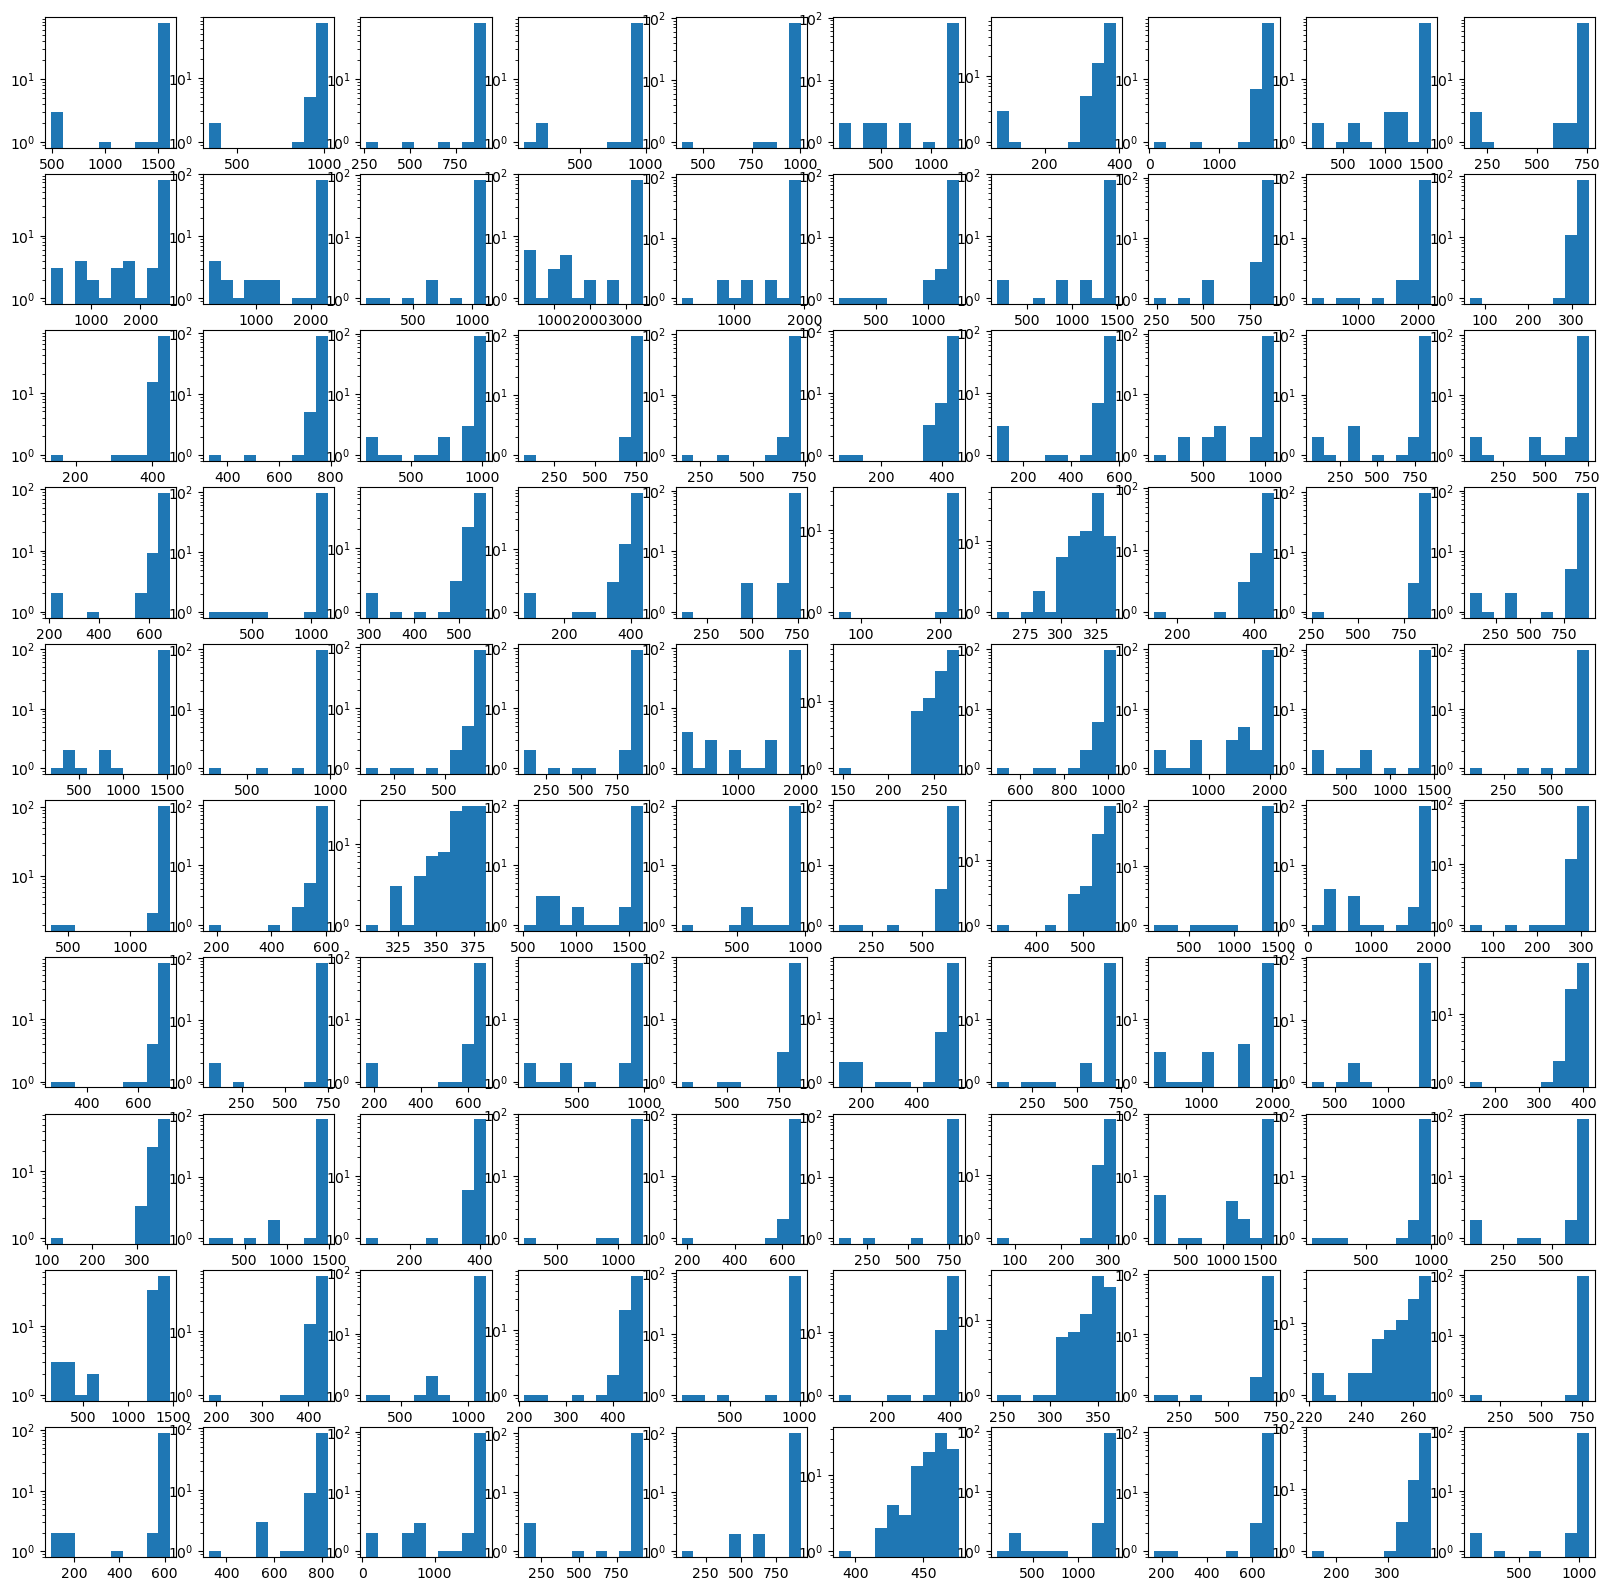

In [9]:
fig, axs = plt.subplots(10,10,figsize = (20,20))
axs = axs.flatten()
for k, (ax,b) in enumerate(zip(axs,list(d.keys())[:100])):
    ax.hist(d[b])
    ax.set_yscale('log')

In [10]:
for b in d:
    print(d[b])

[1290, 1596, 964, 1591, 1554, 1592, 1548, 1577, 1593, 1573, 1575, 1588, 1588, 1586, 1586, 1597, 1544, 1599, 1599, 1595, 1595, 1587, 1601, 1587, 1577, 1577, 1590, 1600, 1585, 1600, 1573, 1596, 1585, 1559, 1581, 1491, 1601, 1587, 1593, 1603, 1591, 1587, 1610, 1587, 1575, 1545, 597, 1575, 1585, 1558, 1598, 1577, 1590, 1593, 1595, 1586, 1583, 1586, 1609, 1586, 1591, 1593, 568, 1604, 1583, 1600, 1590, 1563, 1517, 1605, 1579, 491, 1600, 1572, 1538, 1528, 1580, 1593, 1564, 1553, 1613, 1588]
[1007, 999, 1006, 1010, 999, 986, 939, 989, 1010, 965, 1013, 1004, 999, 950, 1005, 1016, 1023, 1016, 1021, 1018, 1004, 1015, 1016, 1020, 1013, 1014, 982, 1012, 1000, 1012, 1007, 822, 1006, 984, 1004, 1008, 983, 1013, 1008, 1015, 1012, 1013, 1020, 1012, 365, 1010, 1003, 1015, 992, 1016, 1013, 337, 1008, 1013, 1013, 965, 1011, 953, 1005, 1015, 1015, 994, 1000, 954, 1017, 1007, 997, 1006, 1005, 1009, 931, 1010, 1005, 967, 997, 1011, 997, 1018, 994, 1008, 992]
[883, 900, 876, 894, 884, 895, 849, 888, 907, 895,

In [11]:
[np.std(b)  for b in d.values()]

[206.4776178970616,
 104.23384335957739,
 87.38006128689454,
 151.1197235706942,
 70.53899262797037,
 245.2756635117131,
 60.694189930816485,
 200.52491002438884,
 285.1275605622823,
 113.53035961873458,
 612.6852444503461,
 558.050350784243,
 160.46600193741284,
 970.7992137996575,
 261.2360707575241,
 192.85020908692903,
 228.08786372853535,
 88.90516014270487,
 292.82642707973963,
 28.830572314818863,
 35.92030255864363,
 55.706993252393566,
 158.8092120957901,
 73.38166021258687,
 66.88087261143407,
 53.6039761654998,
 84.83887851781,
 165.04057804067457,
 146.56277811570737,
 115.42281692398026,
 68.1026186716364,
 164.44883623169343,
 41.87532528981289,
 53.53427282916,
 79.27027730370789,
 26.001709345519743,
 13.284370131696813,
 35.321809951158215,
 63.23299455189514,
 160.66064828136953,
 241.37106445147452,
 80.54872469076646,
 82.26567972578763,
 140.24296213189407,
 455.55834311101376,
 16.016612690771037,
 68.14935177209925,
 381.1569856537663,
 238.01411541293612,
 70.69

In [12]:
print(len(read_data), len(gene_positions_reads))

14452 14452


In [13]:
l = []
for r,r2 in  zip(read_data.values(),gene_positions_reads.values()):
    if len(r)!=len(r2):
        l.append(r)

In [14]:
d={}
c=0
for ll in l:
    for b in ll:
        b = b[1:]
        if b in d:
            d[b]+=1
        else:
            d[b]=1
        if b=="tnp.yhhI":
            c+=1

In [15]:
c

0

In [16]:
np.array(d.values()).shape

()

In [17]:
has1 = []
for dd,i in d.items():
    if i==max(d.values()):
        has1.append(dd)

In [18]:
has1.sort()

In [19]:
for b in has1:
    print(b)

In [20]:
s= set()
for ll in l:
    s = s.intersection(set(ll))

In [21]:
len(l)

0

In [66]:
read_file = "..//input/all_data/GCA_027944575.1_ASM2794457v1_genomic/gene_calls_without_gene_filtering.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
read_pos_file = "..//input/all_data/GCA_027944575.1_ASM2794457v1_genomic/gene_positions_without_gene_filtering.json"
with open(read_pos_file, 'r') as f:
    gene_positions_reads = json.load(f)
print(sum([len(r) for r in read_data.values()]))
print(sum([len(r) for r in gene_positions_reads.values()]))
print(len(read_data),len(gene_positions_reads))
read_file = "..//input/all_data/GCA_027944575.1_ASM2794457v1_genomic/gene_calls_with_gene_filtering.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
read_pos_file = "..//input/all_data/GCA_027944575.1_ASM2794457v1_genomic/gene_positions_with_gene_filtering.json"
with open(read_pos_file, 'r') as f:
    gene_positions_reads = json.load(f)
print(sum([len(r) for r in read_data.values()]))
print(sum([len(r) for r in gene_positions_reads.values()]))
print(len(read_data),len(gene_positions_reads))
read_file = "..//input/all_data/GCA_027944575.1_ASM2794457v1_genomic/corrected_gene_calls_with_gene_filtering.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
read_pos_file = "..//input/all_data/GCA_027944575.1_ASM2794457v1_genomic/corrected_gene_positions_with_gene_filtering.json"
with open(read_pos_file, 'r') as f:
    gene_positions_reads = json.load(f)
print(sum([len(r) for r in read_data.values()]))
print(sum([len(r) for r in gene_positions_reads.values()]))
print(len(read_data),len(gene_positions_reads))

520113
520113
61525 61525
462513
462513
61191 61191
367781
367781
33116 33116


In [17]:
read_file = "../input/new_data/SRR23044204_1.pandora_gene_calls.json"
with open(read_file, 'r') as f:
    read_data = json.load(f)
read_pos_file = "../input/new_data/SRR23044204_1.pandora_gene_positions.json"
with open(read_pos_file, 'r') as f:
    gene_positions_reads = json.load(f)

print(sum([len(r) for r in read_data.values()]))
print(sum([len(r) for r in gene_positions_reads.values()]))

380533
380533


In [18]:
from Bio import SeqIO

In [19]:
fastq = SeqIO.to_dict(SeqIO.parse("../input/new_data/SRR23044204_1.fastq","fastq"))

In [20]:
for d in [read_data, gene_positions_reads, fastq]:
    print(len(d))
print(len(set(read_data).intersection(set(fastq))))
print(len(set(gene_positions_reads).intersection(set(fastq))))
print(len(set(read_data).intersection(set(gene_positions_reads))))

subset = set(read_data)

14452
14452
14744
14452
14452
14452


In [21]:
s = fastq[list(fastq.keys())[0]].seq

In [22]:
l1 = [len(s.seq) for i,s in fastq.items()]
l2 = [len(s.seq) for i,s in fastq.items() if i in subset]

l3 = [len(s.seq) for i,s in fastq.items() if i not in subset]

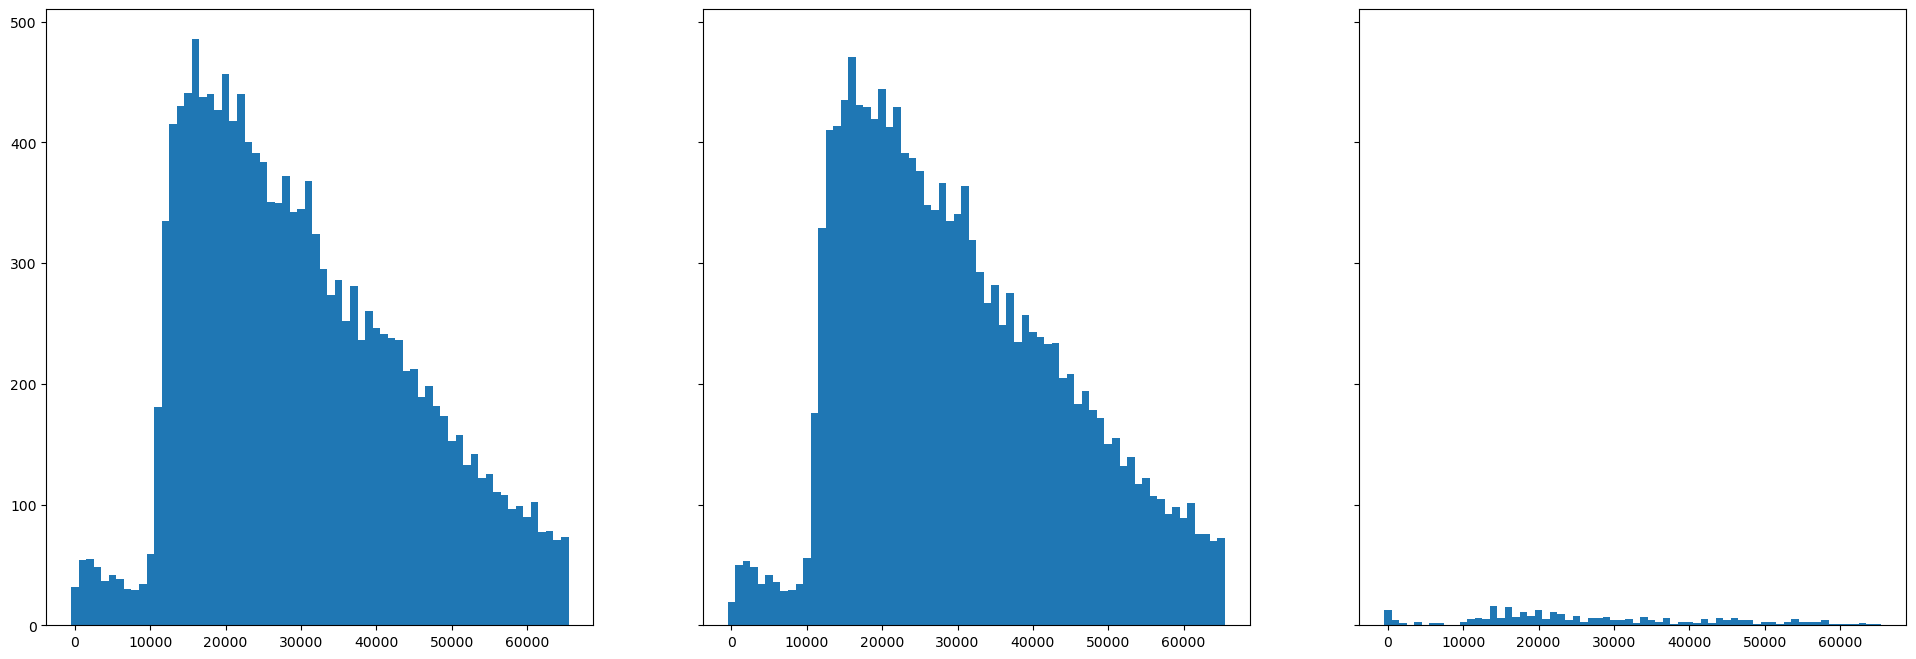

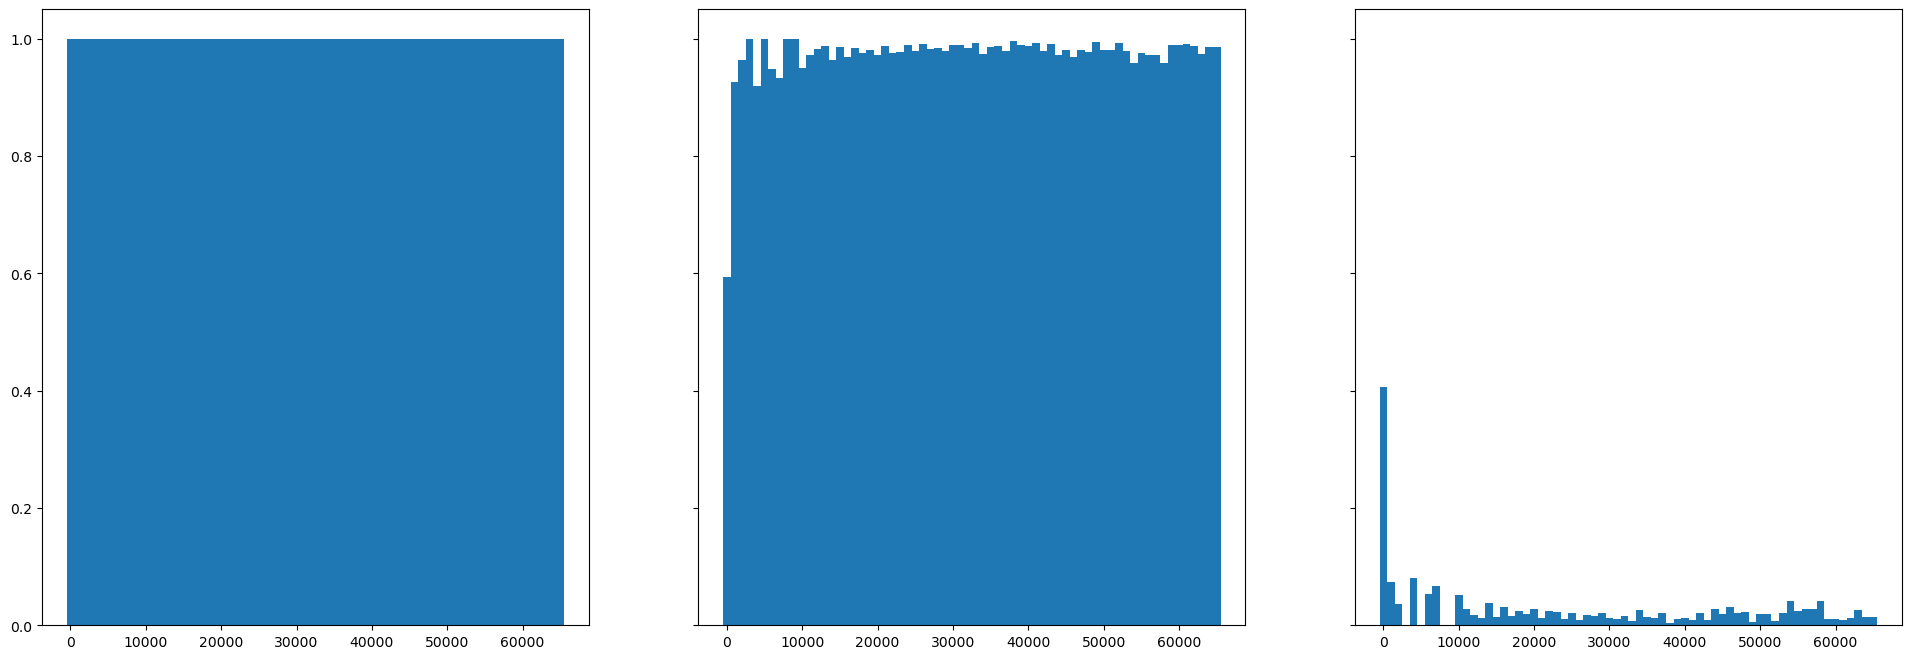

In [23]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize = (24,8))
a1 = axs[0].hist(l1,bins = np.array(range(0,max(l1)+1000,1000))-500)
a2 = axs[1].hist(l2,bins = np.array(range(0,max(l1)+1000,1000))-500)
a3 = axs[2].hist(l3,bins = np.array(range(0,max(l1)+1000,1000))-500)


fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize = (24,8))
axs[0].bar((a1[1][:-1]+a1[1][1:])/2,a1[0]/a1[0],width = 1000)
axs[1].bar((a1[1][:-1]+a1[1][1:])/2,a2[0]/a1[0],width = 1000)
axs[2].bar((a1[1][:-1]+a1[1][1:])/2,a3[0]/a1[0],width = 1000)
pass

In [24]:
blocks2reads = {}
for k,g in read_data.items():
    for block in g:
        add_to_dict(blocks2reads,block[1:],(k,block[0]=="-"))
blocks = list(blocks2reads.keys())
blocks.sort()

alphabet = [("+"+p1,"-"+p1) for p1 in blocks]
bi_alphabet = (alphabet,{k:((i+1)*((-1)**j)) for i, ks in enumerate(alphabet) for j, k in enumerate(ks)})

In [54]:
block_sequences = {k:[] for k in blocks}
for read_id in read_data:
    s_read = fastq[read_id]
    read, read_pos = read_data[read_id], gene_positions_reads[read_id]
    for block, (block_b, block_e) in zip(read, read_pos):
        r = block[0]=="-"
        s = s_read[block_b:block_e+1]
        if r:
            s_r= s.reverse_complement()
            s_r.id, s_r.name, s_r.description = s.id, s.name, s.description
            s = s_r
        block_sequences[block[1:]].append(s)


In [76]:
from time import time

In [75]:
if not os.path.exists("blocks_fasta"):
    os.mkdir("blocks_fasta")
i = 1505
b = blocks[i]
t = time()
with open(os.path.join("blocks_fasta","{}_{}.fasta".format(i,b)), "w") as output_handle:
    SeqIO.write(block_sequences[b], output_handle, "fasta")
print(time()-t)
# plt.hist([len(s) for ])

0.0018088817596435547


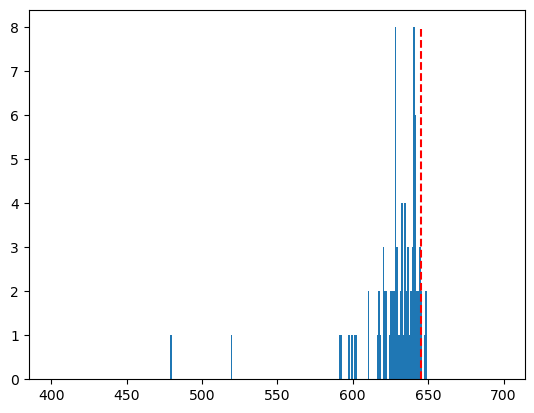

In [83]:
plt.hist([len(s) for s in block_sequences[b]], bins = np.arange(400,700))
plt.vlines(645,0,8, color ="red", linestyles="--")

In [74]:
i = 1505
b = blocks[i]
t = time()
for i,b in enumerate(blocks):
    with open(os.path.join("blocks_fasta","{}_{}.fasta".format(i,b)), "w") as output_handle:
        SeqIO.write(block_sequences[b], output_handle, "fasta")
print(time()-t)
# plt.hist([len(s) for ])

6.350049018859863


In [56]:
len(block_sequences[b])

89

In [26]:
l, m, s, ns, outside, outside_r = [],[],[],[], [],[]
for b in block_sequences:
    l.append([len(bb) for bb in block_sequences[b]])
    m.append(np.median(l[-1]))
    s.append(np.std(l[-1]))
    ns.append(s[-1]/m[-1])
    outside.append(len([ll for ll in l[-1] if ll>(m[-1]*1.5)or ll<(m[-1]*0.5)]))
    outside_r.append(outside[-1]/len(l[-1]))


(array([4.02e+03, 8.70e+01, 7.00e+00, 6.00e+00, 1.60e+01, 3.00e+00,
        2.00e+00, 1.00e+00, 0.00e+00, 2.00e+00]),
 array([0.        , 0.0984456 , 0.19689119, 0.29533679, 0.39378238,
        0.49222798, 0.59067358, 0.68911917, 0.78756477, 0.88601036,
        0.98445596]),
 <BarContainer object of 10 artists>)

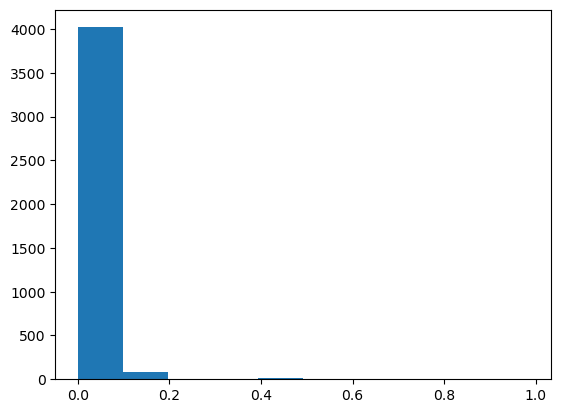

In [32]:
plt.hist(outside_r)

(array([ 44., 100.,   2.,   0.,   6.,  98.,   1.,   2.,   7.,  91.]),
 array([ 39. ,  77.4, 115.8, 154.2, 192.6, 231. , 269.4, 307.8, 346.2,
        384.6, 423. ]),
 <BarContainer object of 10 artists>)

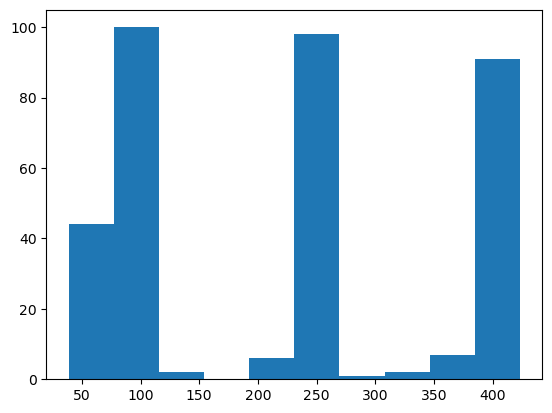

In [33]:
plt.hist(l[273    ])

In [34]:
for i,b in enumerate(block_sequences):
    if outside_r[i]>0.5:
        print(i, b,m[i],s[i], outside[i],outside_r[i])

273 cbrC 241.0 134.90392597907527 241 0.6866096866096866
962 group_115 1566.0 1010.3394650862372 8 0.7272727272727273
964 group_116 390.0 501.60008586399977 84 0.5060240963855421
1134 group_248 547.5 895.7704472152894 171 0.9606741573033708
1448 group_5422 374.0 588.4878563738758 190 0.9844559585492227
4057 ypjC 670.0 393.83851622143834 7 0.6363636363636364


(array([3.910e+02, 1.019e+03, 1.499e+03, 8.970e+02, 2.560e+02, 4.300e+01,
        8.000e+00, 3.000e+00, 4.000e+00, 6.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

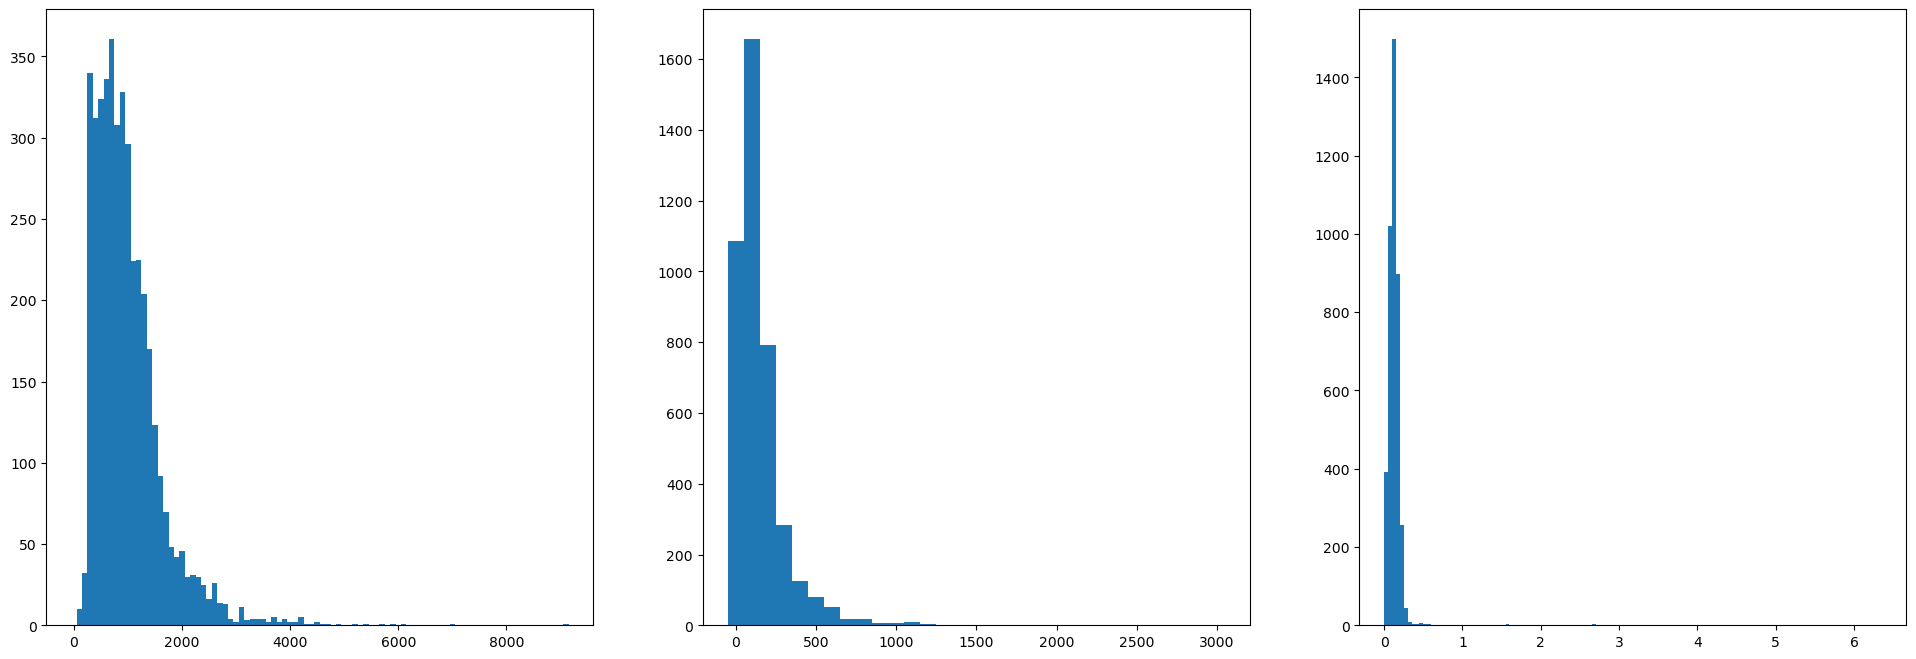

In [35]:
fig, axs = plt.subplots(1,3, figsize = (24,8))
step = 100
axs[0].hist(m,bins = np.array(range(0,np.ceil(max(m)).astype(int)+step,step))-step//2)
axs[1].hist(s,bins = np.array(range(0,np.ceil(max(s)).astype(int)+step,step))-step//2)
axs[2].hist(ns,bins = np.array(range(0,(np.ceil(2000*max(ns)).astype(int)+step),step))/2000-step/2000//2)

In [36]:
m[0]

767.0

In [37]:
block_sequences[blocks[0]][2].__len__()

746

In [259]:
from itertools import product

def needleman_wunsch_inclusion(x, y):
    # get the lengths of x and y
    N, M = len(x), len(y)
    gap_score = 0.5
    def score(a, b):
        # Scoring function: returns 1 if elements are equal, 0 otherwise
        if a in b:
            return 1
        else:
            return -1

    # Direction constants for traceback
    DIAG, LEFT, UP = (-1, -1), (-1, 0), (0, -1)
    # Initialize score (F) and pointer (Ptr) matrices
    F, Ptr = {}, {}
    F[-1, -1] = 0
    # Initial scoring for gaps along x
    for i in range(N):
        # F[i, -1] = -i
        F[i, -1] = 0
    # Initial scoring for gaps along y
    for j in range(M):
        # F[-1, j] = -j
        F[-1, j] = 0
    # Option for Ptr to trace back alignment
    option_Ptr = DIAG, LEFT, UP
    # Fill F and Ptr tables
    for i, j in product(range(N), range(M)):
        # Score options: match/mismatch, gap in x, gap in y
        gap_x = 0 if j == M-1 else gap_score
        gap_y = 0 if i == N-1 else gap_score
        option_F = (
            F[i - 1, j - 1] + score(x[i], y[j]),  # Match/mismatch
            F[i - 1, j] - gap_x,  # Gap in x
            F[i, j - 1] - gap_y,  # Gap in y
        )
        # Choose best option for F and Ptr
        F[i, j], Ptr[i, j] = max(zip(option_F, option_Ptr))
    # Trace back to get the alignment
    alignment_score = F[N-1,M-1]
    alignment = []
    i, j = N - 1, M - 1
    while i >= 0 and j >= 0:
        direction = Ptr[i, j]
        # Add aligned elements or gaps based on direction
        if direction == DIAG:
            element = x[i]
        elif direction == LEFT:
            element = x[i] # Insert gap in y
        elif direction == UP:
            element = "*"  # Insert gap in x
        alignment.append(element)
        di, dj = direction
        i, j = i + di, j + dj
    # Add remaining gaps if any
    while i >= 0:
        alignment.append(x[i])  # Gap in y
        i -= 1
    while j >= 0:
        alignment.append("*")  # Gap in x
        j -= 1
    print(F)
    return alignment[::-1], alignment_score,F

In [255]:

import numpy as np
from time import time 
a, b = [2,3,5,6], [[1],[2],[3,4],[2],[5],[6],[7,8]]

a, b = [2,3,4,5], [[0],[1],[2],[3],[4],[5],[6],[7,8],[9],[10]]

al, s, F = needleman_wunsch_inclusion(a,b)

{(-1, -1): 0, (0, -1): 0, (1, -1): 0, (2, -1): 0, (3, -1): 0, (-1, 0): 0, (-1, 1): 0, (-1, 2): 0, (-1, 3): 0, (-1, 4): 0, (-1, 5): 0, (-1, 6): 0, (-1, 7): 0, (-1, 8): 0, (-1, 9): 0, (0, 0): -0.5, (0, 1): -0.5, (0, 2): 1, (0, 3): 0.5, (0, 4): 0.0, (0, 5): -0.5, (0, 6): -0.5, (0, 7): -0.5, (0, 8): -0.5, (0, 9): 0, (1, 0): -0.5, (1, 1): -1.0, (1, 2): 0.5, (1, 3): 2, (1, 4): 1.5, (1, 5): 1.0, (1, 6): 0.5, (1, 7): 0.0, (1, 8): -0.5, (1, 9): 0, (2, 0): -0.5, (2, 1): -1.0, (2, 2): 0.0, (2, 3): 1.5, (2, 4): 3, (2, 5): 2.5, (2, 6): 2.0, (2, 7): 1.5, (2, 8): 1.0, (2, 9): 0.5, (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 1.0, (3, 4): 2.5, (3, 5): 4, (3, 6): 4, (3, 7): 4, (3, 8): 4, (3, 9): 4}


In [260]:
shape = [i+2 for i in max(F)]
m = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        m[i,j]=F[i-1,j-1]

In [257]:
al

['*', '*', 2, 3, 4, 5, '*', '*', '*', '*']

In [258]:
m

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.5, -0.5,  1. ,  0.5,  0. , -0.5, -0.5, -0.5, -0.5,  0. ],
       [ 0. , -0.5, -1. ,  0.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5,  0. ],
       [ 0. , -0.5, -1. ,  0. ,  1.5,  3. ,  2.5,  2. ,  1.5,  1. ,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  1. ,  2.5,  4. ,  4. ,  4. ,  4. ,  4. ]])

In [190]:
from time import time  

In [199]:
c = 0
t=time()
for s in read_seqs:
    c+=1
    a = s.num(canonical=False)
    b = consensus_set[:30]
    needleman_wunsch_inclusion(a,b)[1]
    if c==100:
        break
print(time()-t)


0.26604366302490234


In [200]:
len(read_seqs)/100*0.26

37.5752

In [198]:
4826.968/3600

1.3408244444444444

In [151]:
consensus_set[:3]

[{1199}, {1199}, {-491}]

In [149]:
dd

[{1199}, {1199}, {-491}]


In [145]:
l=[]
for read_id in read_data:
    l.append(len(fastq[read_id]))

NameError: name 'fastq' is not defined

In [7]:
m = np.zeros((len(l),max(l)))
inter_blocks =[]
for i, read_id in enumerate(read_data):
    m[i,0:(l[i])]=1
    read_pos =  gene_positions_reads[read_id]
    oe = None
    inter_blocks.append([0])
    for (block_b, block_e) in read_pos:
        m[i,block_b:(block_e+1)]+=1
        if oe is not None:
            inter_blocks[-1].append(block_b-oe)
        oe = block_e
    
ml = list(m)
ml.sort(key=lambda x: sum(x>0))
ml = np.array(ml)
m = m.astype(np.int8)
ml = ml.astype(np.int8)

In [8]:
a_inter_blocks = [x for xs in inter_blocks for x in xs]
# a_inter_blocks.flatten()

[Text(0, 0.5, 'Number of reads (log)'),
 Text(0, 0.5, 'Number of reads (log)'),
 Text(0, 0.5, 'Number of reads (log)'),
 Text(0, 0.5, 'Number of reads (log)'),
 Text(0, 0.5, 'Number of reads (log)'),
 Text(0, 0.5, 'Number of reads (log)')]

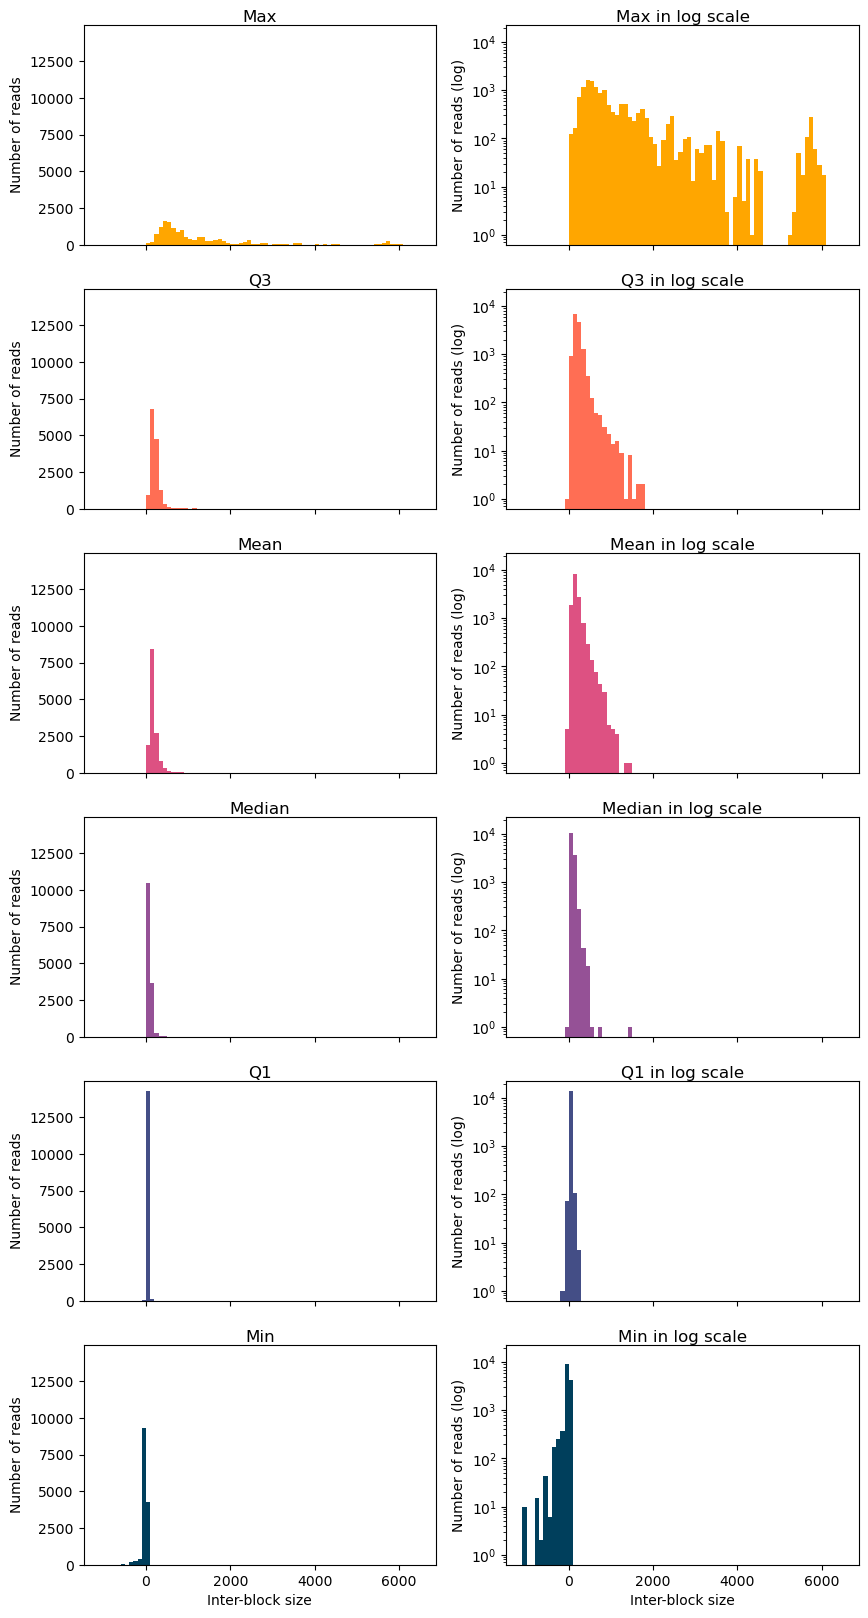

In [10]:
fig, axs = plt.subplots(6,2, sharex=True, sharey="col", figsize = (10,20))
# plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -14
fun_names = ["Max","Q3","Mean","Median","Q1", "Min"]
fun_cols = ["#003f5c","#444e86","#955196","#dd5182","#ff6e54","#ffa600"][::-1]
funs = [np.max, lambda x: np.quantile(x,0.75), np.mean,np.median,lambda x: np.quantile(x,0.25),np.min]

bins = np.arange(min(a_inter_blocks), max(a_inter_blocks)+100,100)-50
for i,f in enumerate(funs):
    c= fun_cols[i]
    a= [f(x) for x in inter_blocks]
    axs[i,0].hist(a,bins,color=c)
    axs[i,0].set_title(fun_names[i])
    axs[i,1].hist(a,bins, color = c)
    axs[i,1].set_title(fun_names[i]+" in log scale")
    axs[i,1].set_yscale("log")
axs[-1,0].set_xlabel("Inter-block size")
axs[-1,1].set_xlabel("Inter-block size")
[ax.set_ylabel("Number of reads") for ax in axs[:,0]]
[ax.set_ylabel("Number of reads (log)") for ax in axs[:,1]]
    

0.5441634104733339 354555.2609503395


Text(0, 0.5, 'Number of blocks (log)')

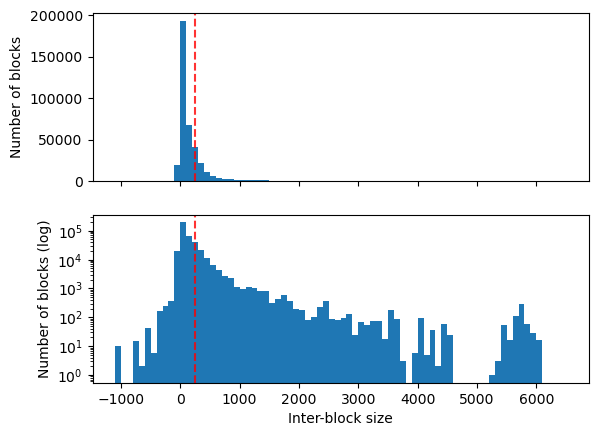

In [72]:


fig, axs = plt.subplots(2,1, sharex=True)
axs[0].hist(a_inter_blocks, bins = np.arange(min(a_inter_blocks), max(a_inter_blocks)+100,100)-50)
ymin, ymax = axs[0].get_ylim()
axs[0].set_ylim(ymin, ymax)
axs[0].vlines(250,ymin,ymax, color = 'red',  alpha = 0.8,  linestyle = '--')
axs[1].hist(a_inter_blocks, bins = np.arange(min(a_inter_blocks), max(a_inter_blocks)+100,100)-50)
axs[1].set_yscale("log")
ymin, ymax = axs[1].get_ylim()
print(ymin,ymax)
axs[1].set_ylim(ymin, ymax)
axs[1].vlines(250,ymin,ymax, color = 'red',  alpha = 0.8,  linestyle = '--')
axs[1].set_xlabel("Inter-block size")
axs[0].set_ylabel("Number of blocks")
axs[1].set_ylabel("Number of blocks (log)")

In [46]:
l_count = []
for mm in m:
    x = mm[mm>0]
    l_count.append([sum(x==1),sum(x==2),sum(x==3)])

In [44]:
ml=list(m)
type(ml[0])

numpy.ndarray

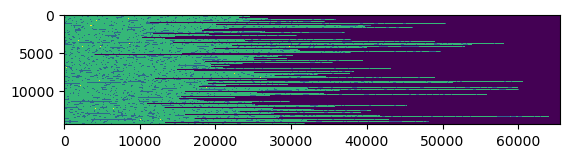

In [42]:
plt.imshow(m, interpolation='none')

In [121]:
from matplotlib import colors
# make a color map of fixed colors
cmap = colors.ListedColormap(['grey', "white", "green", "red"])
bounds=[-0.5,0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# # tell imshow about color map so that only set colors are used
# img = plt.imshow(zvals, interpolation='nearest', origin='lower',
#                     cmap=cmap, norm=norm)


NameError: name 'img' is not defined

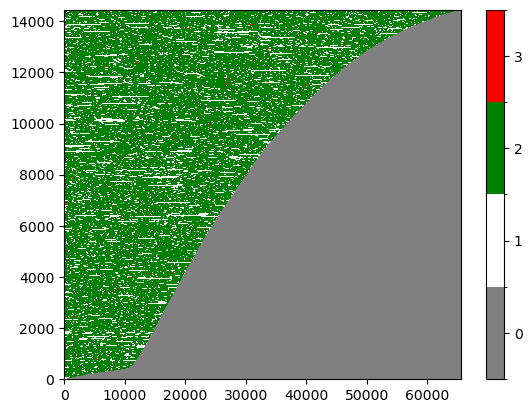

In [14]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(ml, interpolation="none", aspect='auto',origin='lower',
                    cmap=cmap, norm=norm)
# make a color bar
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2,3])

fig.savefig('block_in_reads.png',dpi = 1000)



In [47]:
c1 = [(l_count[i][0])/l[i] for i in range(len(m))]
c23 = [(l_count[i][1]+l_count[i][2])/l[i] for i in range(len(m))]
c2 = [(l_count[i][1])/l[i] for i in range(len(m))]
c3 = [(l_count[i][2])/l[i] for i in range(len(m))]


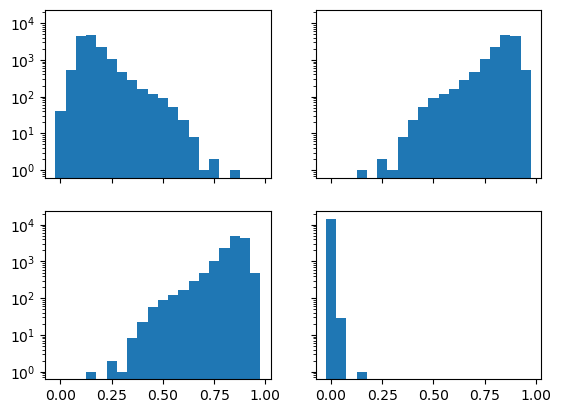

In [56]:
fig, axs = plt.subplots(2,2,sharex=True,sharey=True)
axs = axs.flatten()

bins = list(np.arange(0,1.05,0.05)-0.025)
axs[0].hist(c1,bins)
axs[0].set_yscale('log')
axs[1].hist(c23,bins)
axs[1].set_yscale('log')
axs[2].hist(c2,bins)
axs[2].set_yscale('log')
axs[3].hist(c3,bins)
axs[3].set_yscale('log')


{'whiskers': [<matplotlib.lines.Line2D at 0x7341bb1548b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7341bb154df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7341bb1545e0>,
 'medians': [<matplotlib.lines.Line2D at 0x7341bb155330>,
 'fliers': [<matplotlib.lines.Line2D at 0x7341bb1555d0>,
 'means': []}

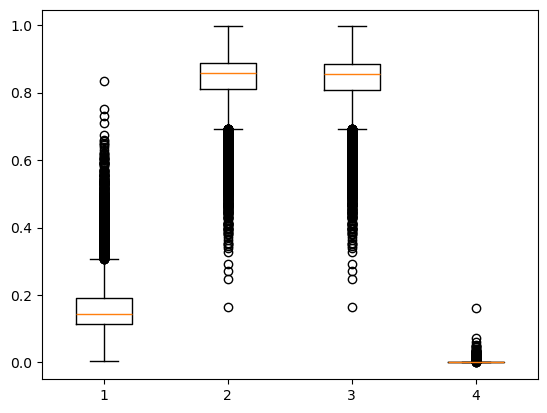

In [60]:
plt.boxplot([c1,c23,c2,c3])

In [7]:
len(read_data)

14452

In [8]:
seq = ["+kdsA","-chaA","+chaC","-ychN","+ychO","-group_2250","-narX","+narK","+group_237","+group_237"]
seq1 = ["+kdsA","-chaA","+chaC","-ychN","+ychO","-group_2250","-narX","+narK","+group_237"]
seq2 = ["-chaA","+chaC","-ychN","+ychO","-group_2250","-narX","+narK","+group_237","+group_237"]

In [362]:
from data.data import Sequence

s = Sequence(0,numseq2bytes(seq2num(seq2,bi_alphabet),Sequence.n_b),1)

In [363]:
s1,s2 = s.blocks(),s.blocks(canonical=False)

In [365]:
for d in read_data.values():
    for s in [s1,s2]:
        for k in range(len(d)-len(s)):
            # print(len(s),len(d[k:k+10]))
            # if s == d[k:k+len(s)+1]:
            if s == d[k:k+9]:
                print(s[:],d[k-1:k+11])
                # print(s[:]==d[k:k+10])

['-chaA', '+chaC', '-ychN', '+ychO', '-group_2250', '-narX', '+narK', '+group_237', '+group_237'] ['-group_5897', '-chaA', '+chaC', '-ychN', '+ychO', '-group_2250', '-narX', '+narK', '+group_237', '+group_237', '+group_519', '+narJ']


In [244]:
x,y , z = [],[] , []
l = []
c = 0
for r in gene_positions_reads:
    e = None
    for i,b in enumerate(gene_positions_reads[r]):
        c+=1
        ns, ne = b
        if e is not None:
            l.append(ns-e)
        e= ne
        x.append(list(b))
        y.append([i,i])
        z.append([j,j])

In [245]:
c

380533

In [242]:
c

358353

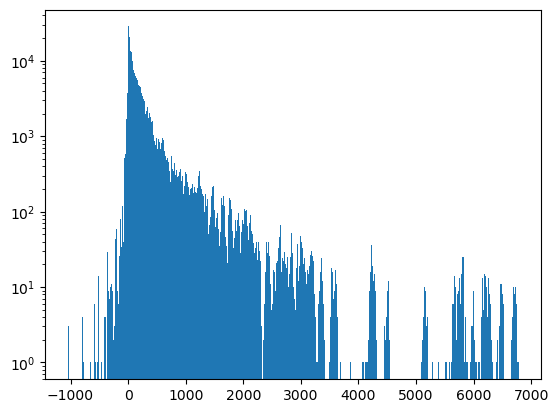

In [240]:
plt.hist(l, bins = range(min(l),max(l)+10,10))
plt.yscale("log")

In [231]:
l

[311, 26, 15, 28, 34, 278, 27, 206, 499, 15, 46, 7, -14, 145, 194, 228]

In [230]:
gene_positions_reads[r]

[[22, 1312],
 [1623, 2630],
 [2656, 3539],
 [3554, 4529],
 [4557, 5522],
 [5556, 6812],
 [7090, 7452],
 [7479, 9140],
 [9346, 10873],
 [11372, 12111],
 [12126, 14736],
 [14782, 17089],
 [17096, 18183],
 [18169, 21600],
 [21745, 23675],
 [23869, 25146],
 [25374, 26239]]

 ...]

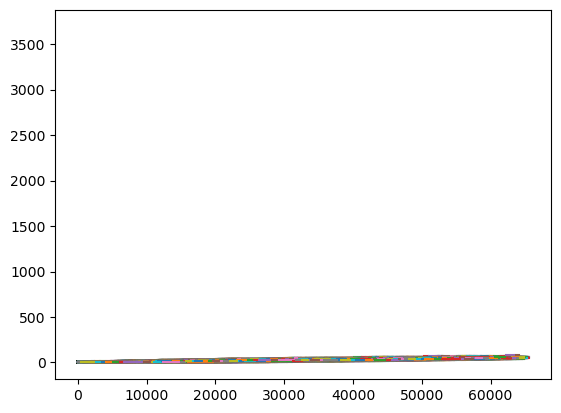

In [237]:
plt.plot(np.array(x).T,np.array(y).T,np.array(z).T)

In [10]:
import gfapy

In [19]:
a = gfapy.Gfa().from_file("../input/new_data/GFAs/post_correction/gene_mer_graph.k_7_short.gfa")
plasmid = [n.split("~~~") for n in a.names]
plasmid = [Sequence(k, numseq2bytes(seq2num(seq, bi_alphabet),n_b=2),1) for k, seq in enumerate(plasmid)]


In [12]:
# from data.data import Sequence
# from common.utils import seq2num, numseq2bytes
# from graph.graph import get_kmer_count_from_sequences, get_unitigs_bcalm
# plasmid = ["+group_3621~~~-group_3790~~~-chrA~~~-sul1NG_0480981~~~+group_3621~~~-group_3790~~~-chrA".split("~~~")]
# alphabet = [("+"+p1[1:],"-"+p1[1:]) for p1 in plasmid[0]]
# bi_alphabet = (alphabet,{k:((i+1)*((-1)**j)) for i, ks in enumerate(alphabet) for j, k in enumerate(ks)})
# Sequence.n_b = 2
# plasmid = [Sequence(k, numseq2bytes(seq2num(seq, bi_alphabet),n_b=2),1) for k, seq in enumerate(plasmid)]

# k=3
# kmers = get_kmer_count_from_sequences(plasmid, k=k, cyclic=False)
# [kmer.compute_abundance("max_unitigs_reads") for kmer in kmers]
# kmers.compute_edges(k)
# unitigs = get_unitigs_bcalm(kmers, k, on_unitig=False)
# unitigs.compute_edges(k)
# print(unitigs.get_edges())
# for u in unitigs:
#     print(len(u),u.num())


In [20]:
k=7
kmers = get_kmer_count_from_sequences(plasmid, k=k, cyclic=False)
[kmer.compute_abundance("max_unitigs_reads") for kmer in kmers]
kmers.compute_edges(k)
unitigs = get_unitigs_bcalm(kmers, k, on_unitig=False)
unitigs.compute_edges(k)

[(3, 3, 1),
 (1, 3, 2),
 (4, 4, 1),
 (1, 2, 2),
 (1, 2, -2),
 (2, 3, 1),
 (0, 0, 1),
 (0, 2, -2),
 (0, 1, 1)]

In [21]:
g_cleaned = get_gt_graph(unitigs)
g_cleaned.save(os.path.join(RES_OUTPUT_FOLDER,"c_graph_clean_{}k_{}_{}.graphml".format("OOPS",7,7)))

In [22]:
print(unitigs.get_edges())
for u in unitigs:
    print(len(u),u.num()[:10], u.num()[-10:])

[(0, 0, 1), (0, 1, 1), (0, 2, -2), (1, 2, 2), (1, 2, -2), (1, 3, 2), (2, 3, 1), (3, 3, 1), (4, 4, 1)]
9 [  269  2061 -2062   269  2061 -2062   269  2061 -2062] [  269  2061 -2062   269  2061 -2062   269  2061 -2062]
33 [  269  2061 -2062   269  2061 -2062   781  2017  1063  2015] [-2944 -3558 -2517  1369 -1394 -1370 -4089 -1074 -1759 -1323]
44 [ 2062 -2061  -269  2062 -2061  -269 -2037  1632  1489 -1570] [ 1103  1478 -2370 -2368  1323  1759  1074  4089  1370  1394]
110 [ 1323  1759  1074  4089  1370  1394  1425  3420  1971 -1410] [3873 3260 3529 3545 1323 1759 1074 4089 1370 1394]
4038 [ -77 2399   79   80   75   76 1951   78 2398 1415] [-921  918 3108 4456  -77 2399   79   80   75   76]


+group_3621~~~-group_3790~~~-chrA~~~-sul1NG_0480981~~~-qacEdelta1~~~-aadA5~~~-dfrA17~~~+xerD.intI1~~~+group_5456~~~-group_4153~~~+group_86~~~-tetRA~~~+group_5882~~~-group_1600~~~-group_2409~~~-pemK~~~-pemI~~~-mcmM~~~-repA~~~-copB.repA2~~~-group_75~~~-group_5493~~~-group_111~~~-group_2375~~~-finO~~~-group_5439~~~-traI~~~+vapC~~~-group_215~~~-traT~~~-group_5204~~~-traG~~~-traH~~~-group_3809~~~-trbB~~~-traQ~~~-trbA~~~-traF~~~-trbE~~~-traN~~~-trbC~~~-traU~~~-traW~~~-trbI~~~-traC~~~-traV~~~-trbG~~~-traP~~~-traB~~~-traK~~~-traE~~~-traL~~~-traA~~~-group_2267~~~-group_5437~~~+yubQ~~~-yubP~~~-yubO~~~-group_5439~~~-group_2349~~~+group_3722~~~-group_636~~~-rafD~~~-rafB~~~-rafA~~~-rafR~~~-group_5150~~~-group_5298~~~+group_2867~~~-group_5435~~~-rsmA~~~-group_30~~~-group_28~~~-group_27~~~-ychA~~~-group_121~~~-group_477~~~-group_25~~~-spo0J~~~-sopA~~~-repB.repE~~~-xerD~~~-ccdB~~~+vapC.pilT~~~+group_499~~~+group_5240~~~+group_3722~~~-group_3905~~~+group_2788~~~+nqrC~~~+group_306~~~+group_2707~~~+group

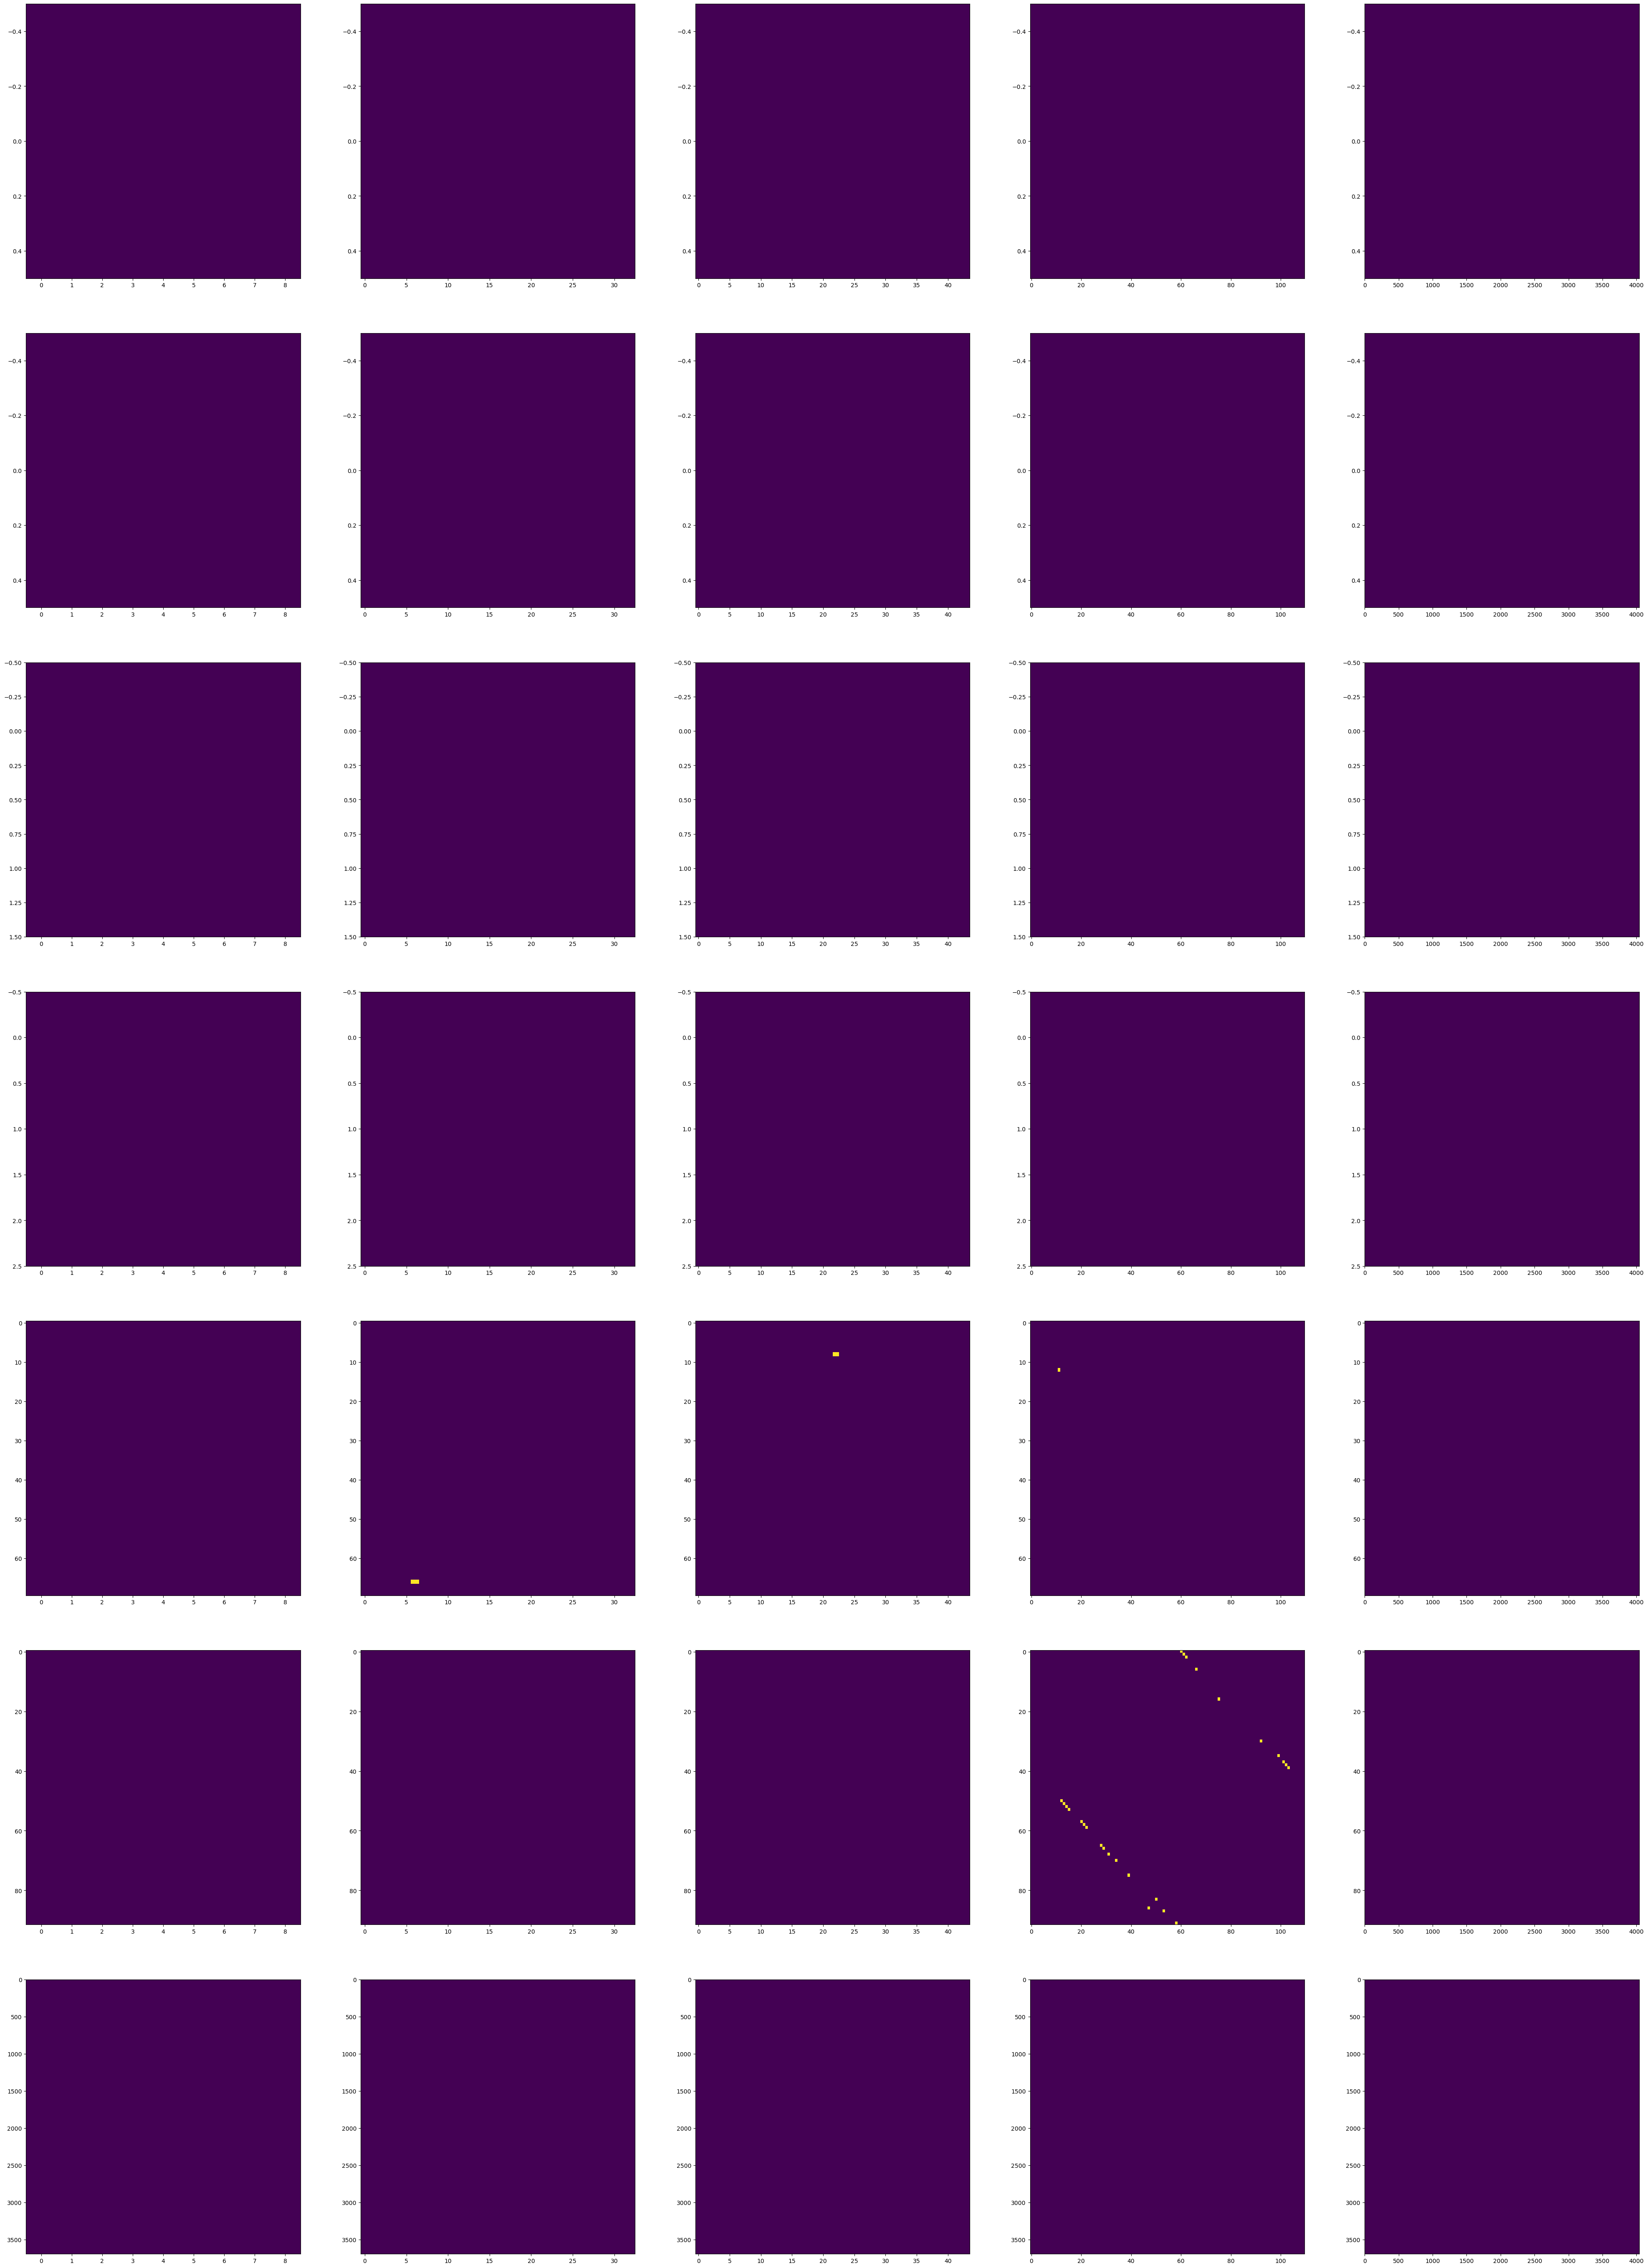

In [55]:
l1,l2 = len(ref_seqs), len(unitigs)
unitigs = sorted(unitigs, key=len)
ref_seqs.sort(key=len)

m = [[] for i in range(l1)]
for i1,u1 in enumerate(ref_seqs):
    s1=u1.num()
    for i2,u2 in enumerate(unitigs):
        s2 = u2.num()
        mi = []
        for _ in range(2):
            mi.append(np.zeros((len(s1),len(s2))))
            for i, ei in enumerate(s1):
                for j, ej in enumerate(s2):
                    if ei==ej:
                        mi[-1][i,j]=1
        mi = max(mi, key=lambda x: x.sum())
        m[i1].append(mi)
fig, axs = plt.subplots(l1,l2, figsize=(l2*10,l1*10))
for i in range(len(m)):
    for j in range(len(m[i])):
        axs[i,j].imshow(m[i][j], interpolation ="none")
        axs[i,j].set_aspect(m[i][j].shape[1]/m[i][j].shape[0])

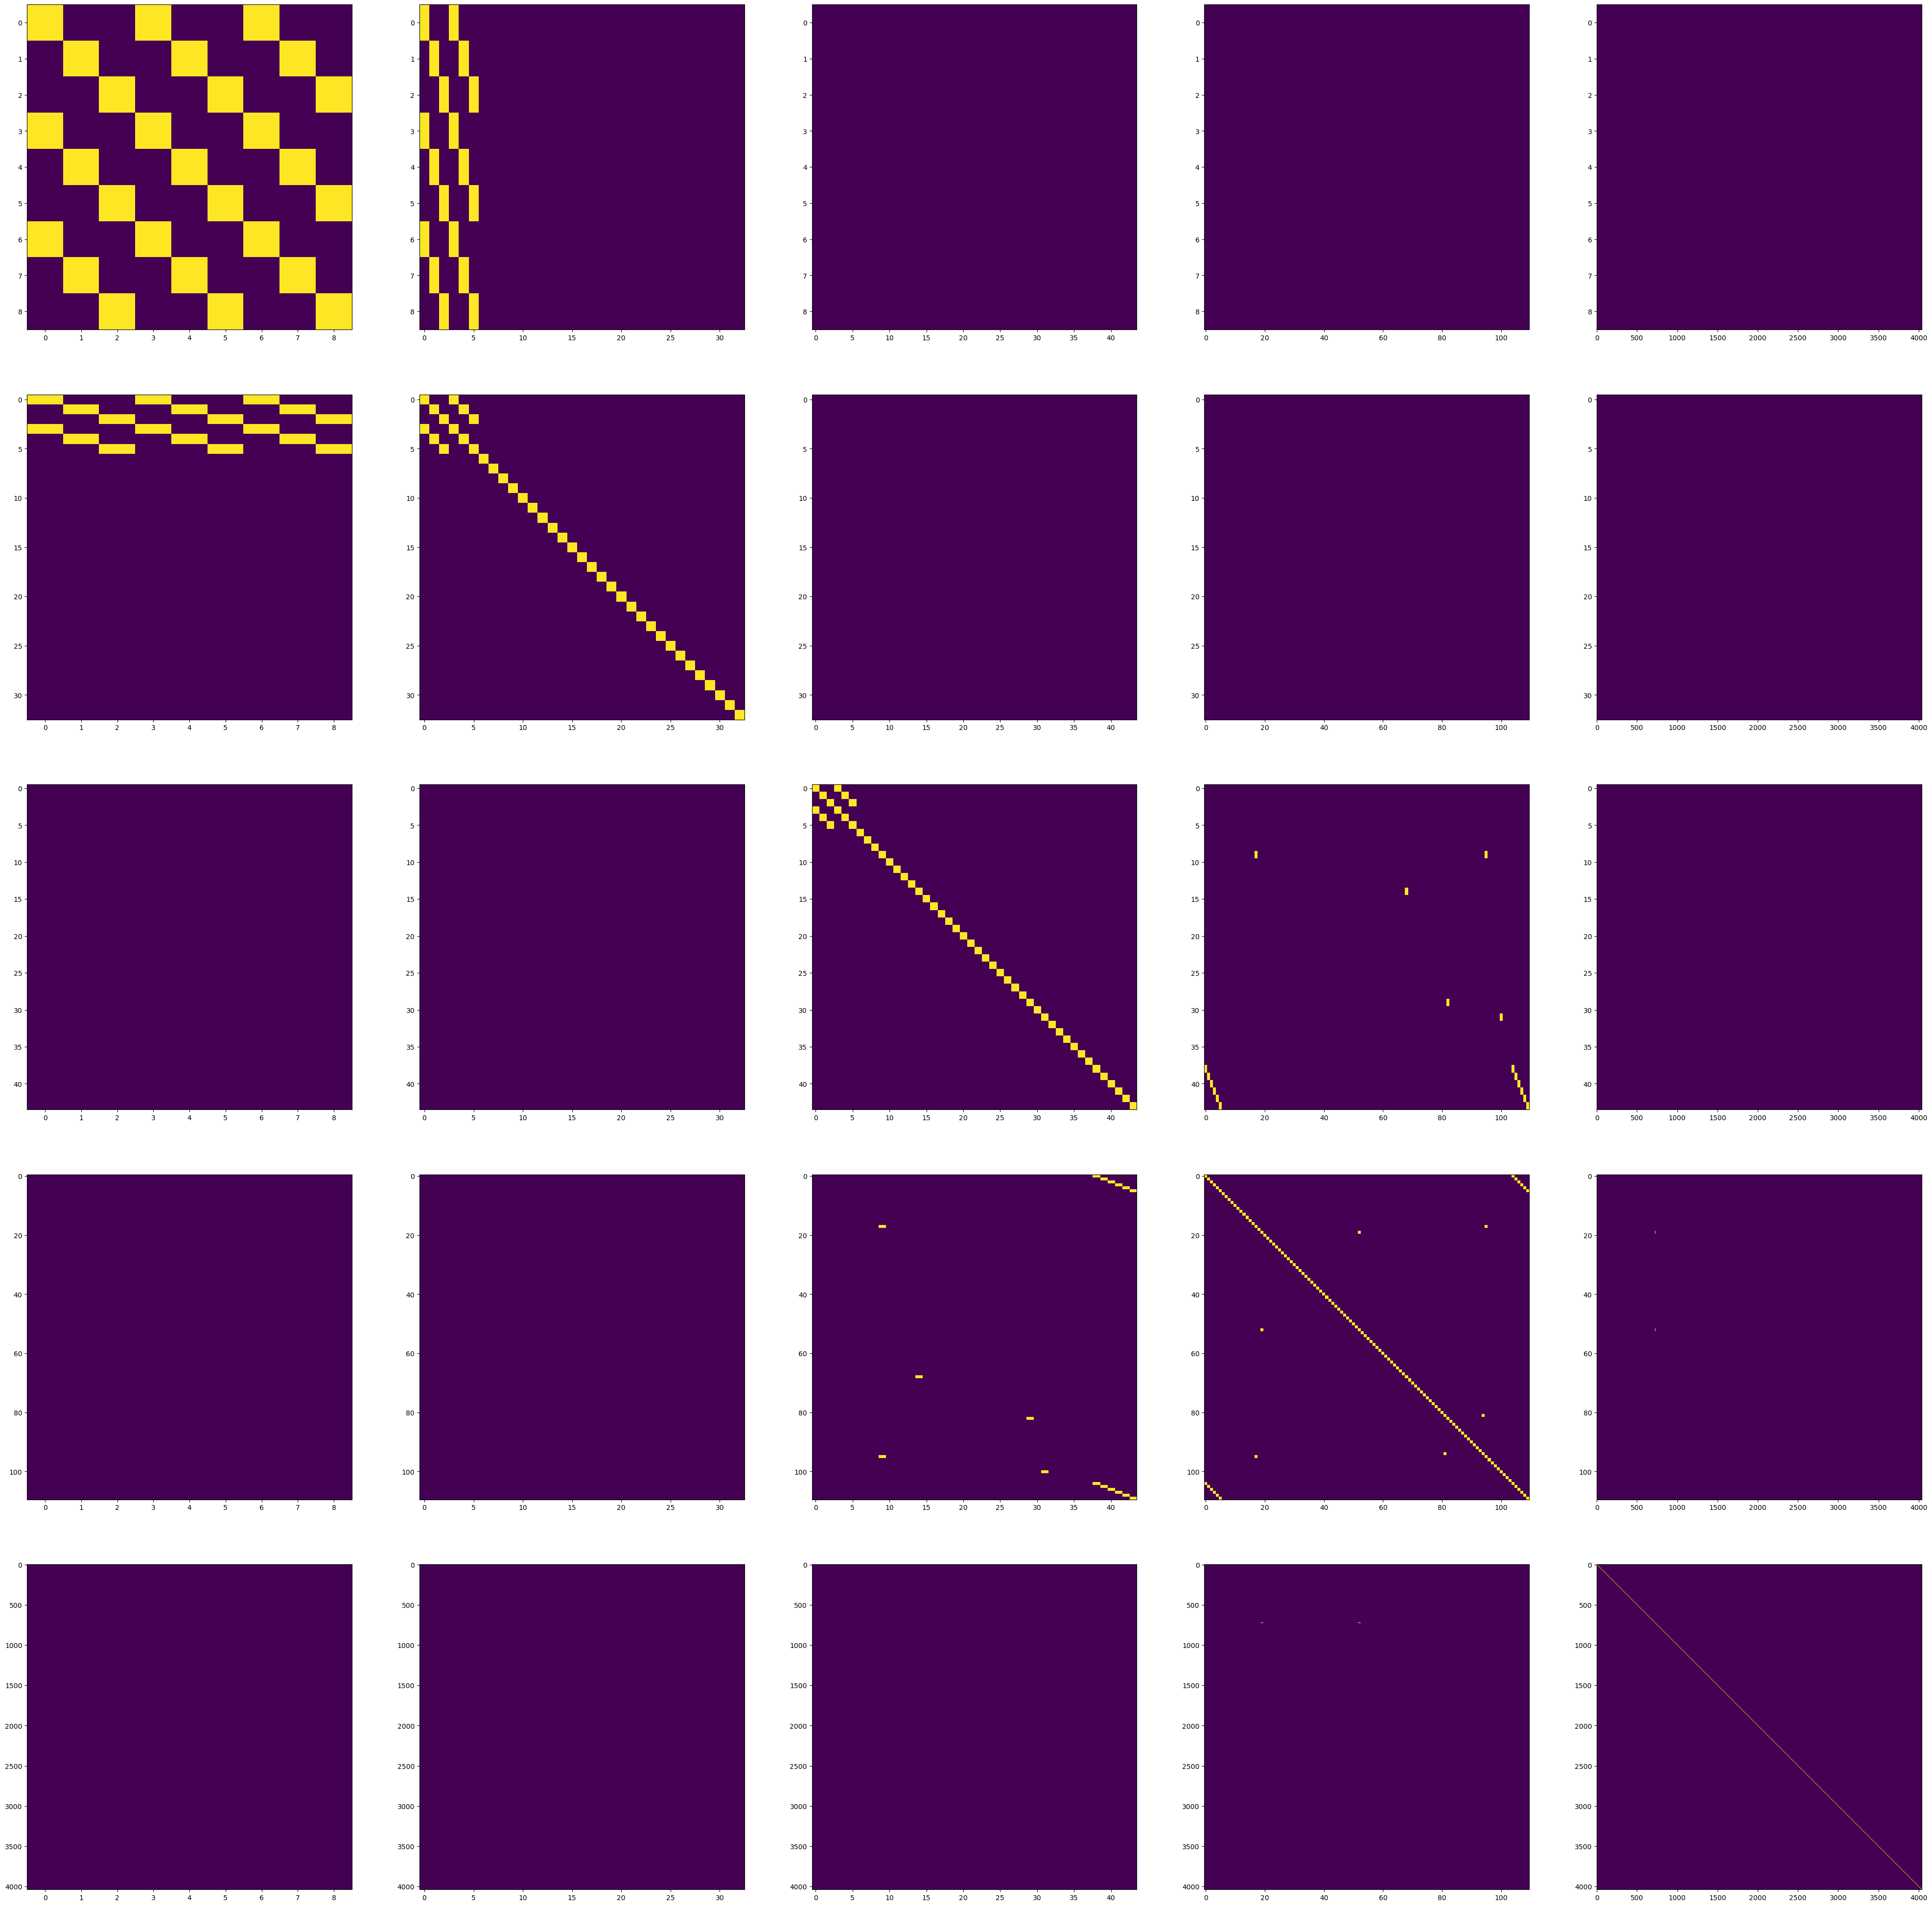

In [56]:
l1,l2 = len(unitigs), len(unitigs)
# unitigs = sorted(unitigs, key=len)
# ref_seqs.sort(key=len)

m = [[] for i in range(l1)]
for i1,u1 in enumerate(unitigs):
    s1=u1.num()
    for i2,u2 in enumerate(unitigs):
        s2 = u2.num()
        mi = []
        for _ in range(2):
            mi.append(np.zeros((len(s1),len(s2))))
            for i, ei in enumerate(s1):
                for j, ej in enumerate(s2):
                    if ei==ej:
                        mi[-1][i,j]=1
        mi = max(mi, key=lambda x: x.sum())
        m[i1].append(mi)
fig, axs = plt.subplots(l1,l2, figsize=(l2*10,l1*10))
for i in range(len(m)):
    for j in range(len(m[i])):
        axs[i,j].imshow(m[i][j], interpolation ="none")
        axs[i,j].set_aspect(m[i][j].shape[1]/m[i][j].shape[0])

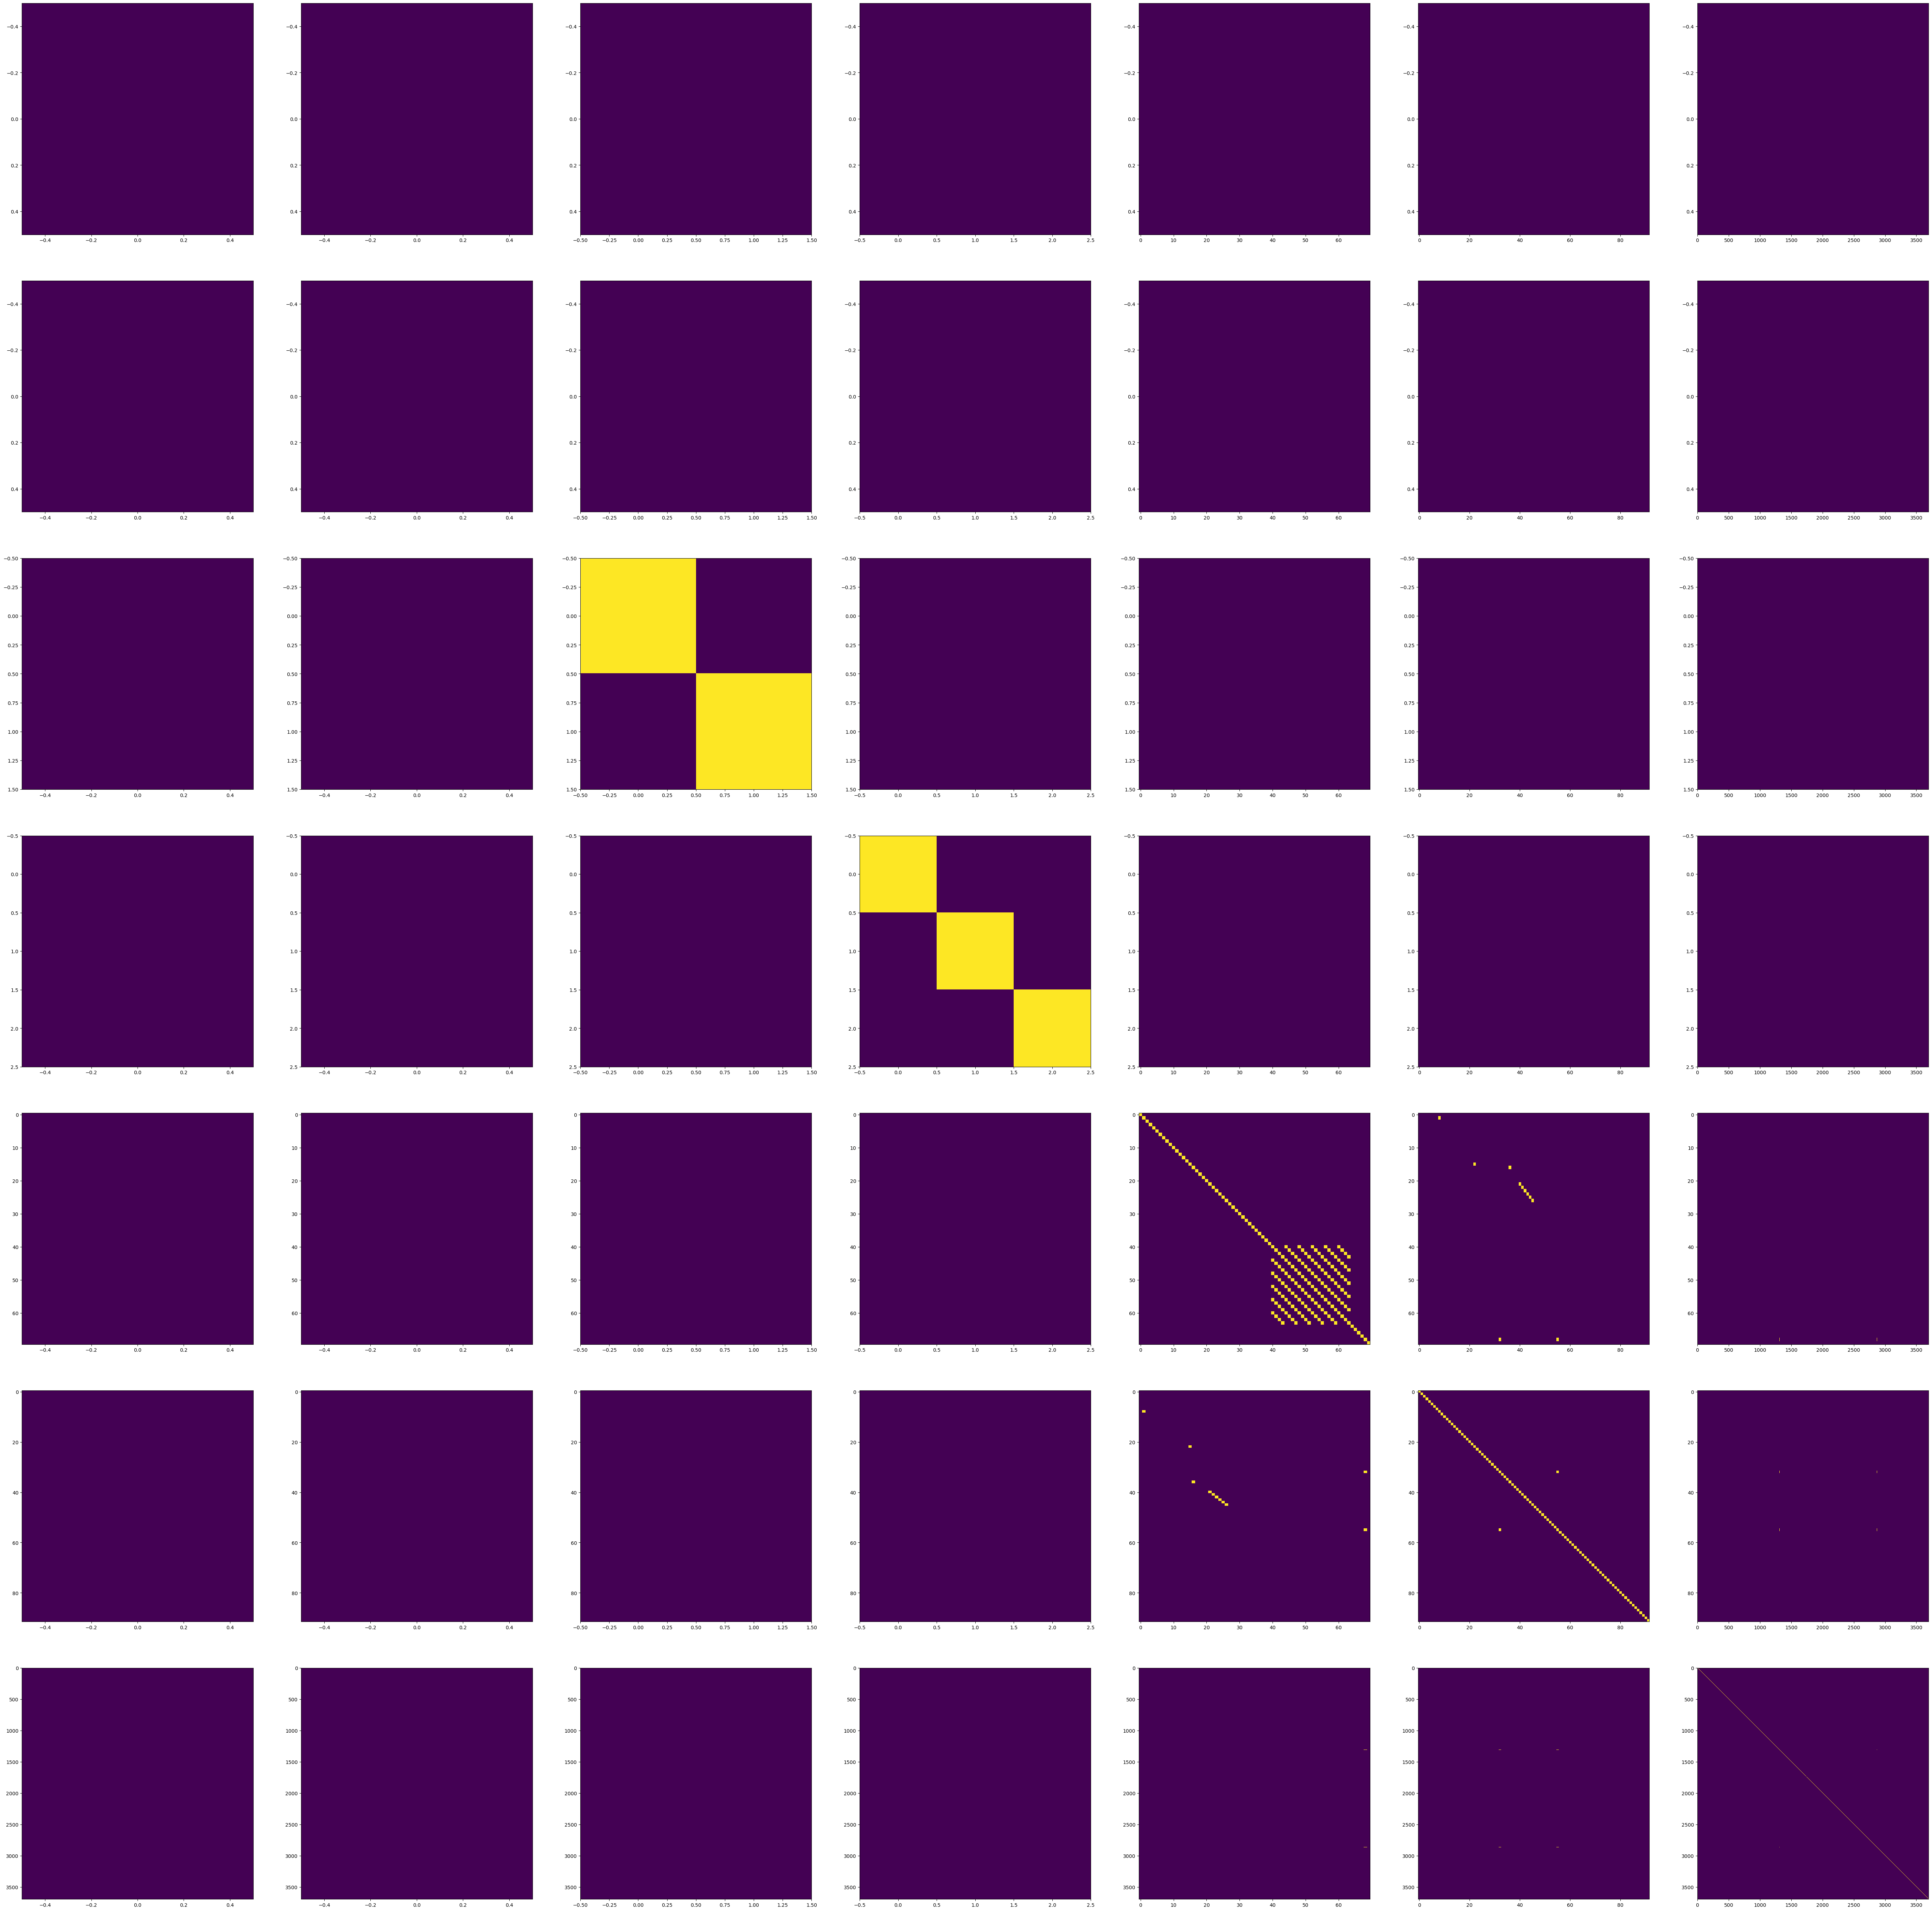

In [57]:
l1,l2 = len(ref_seqs), len(ref_seqs)
# unitigs = sorted(unitigs, key=len)
# ref_seqs.sort(key=len)

m = [[] for i in range(l1)]
for i1,u1 in enumerate(ref_seqs):
    s1=u1.num()
    for i2,u2 in enumerate(ref_seqs):
        s2 = u2.num()
        mi = []
        for _ in range(2):
            mi.append(np.zeros((len(s1),len(s2))))
            for i, ei in enumerate(s1):
                for j, ej in enumerate(s2):
                    if ei==ej:
                        mi[-1][i,j]=1
        mi = max(mi, key=lambda x: x.sum())
        m[i1].append(mi)
fig, axs = plt.subplots(l1,l2, figsize=(l2*10,l1*10))
for i in range(len(m)):
    for j in range(len(m[i])):
        axs[i,j].imshow(m[i][j], interpolation ="none")
        axs[i,j].set_aspect(m[i][j].shape[1]/m[i][j].shape[0])

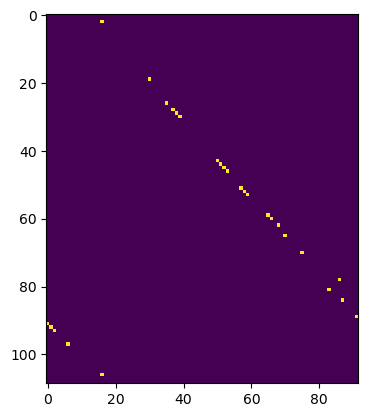

In [500]:
plt.imshow(m)

In [490]:
len(s2)

92

In [491]:
print(m.sum())

0.0


In [492]:
bi_alphabet[1]["+mcmM"]

2568

In [496]:
sum([ss== -2568 for ss in s1])

1

In [61]:
ref_seqs[4].__str__()

'+group_4453~~~+group_5124~~~-group_5233~~~+group_3631~~~+group_3632~~~+group_3633~~~-group_3634~~~-group_4779~~~-korC~~~-group_3034~~~-group_3033~~~+group_5151~~~+group_5150~~~+group_5230~~~+group_5229~~~-group_5124~~~+group_5152~~~-group_805~~~-group_806~~~+parM~~~-group_5110~~~+group_5111~~~+group_5112~~~+group_5128~~~+group_5129~~~+group_5113~~~+group_5114~~~+group_3636~~~+spo0J.parB~~~+psiB~~~+group_727~~~+ardA~~~+pndC~~~+ydfB~~~-group_4892~~~+group_4893~~~-group_4894~~~-trbC~~~-trbB~~~-group_4748~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.blaCMY146~~~-group_5021~~~+group_5031~~~-group_5030~~~-CMY543002065HM5440391011521036.

In [87]:
l={}
for r in ref_seqs[:4]:
    for k in r.num():
        l[abs(k)]=[]


In [88]:
l

{1932: [], 1927: [], 1923: [], 1924: [], 1919: [], 1920: [], 1918: []}

In [104]:
for i, s in enumerate(subseq):
    for k in s.num():
        if abs(k) in l:
            l[abs(k)].append(i)
            if len(s)<5:
                print(str(s))


+group_116~~~+group_5281
-group_5274~~~+acrA~~~+acrB


In [97]:
[(k,len(lm)) for k,lm in l.items()]

[(1932, 95),
 (1927, 0),
 (1923, 78),
 (1924, 0),
 (1919, 94),
 (1920, 0),
 (1918, 94)]

In [104]:
for r in ref_seqs[:4]:
    print(r.num(), str(r))

[  587  3250  2211 ... -2674 -4560 -3344] +dnaN~~~+recF~~~+gyrB3003303AP0090481376029537627102063.gyrB~~~+yidB~~~+yidA~~~-yidX~~~+dgoR~~~+dgoK~~~+dgoA~~~+dgoD~~~+dgoT.uhpC~~~-cbrA~~~+yidR~~~-yidQ~~~+ibpA~~~+ibpB~~~+yidE~~~-yidP~~~+glvB~~~-yidL~~~+yidK~~~+aslA.yidJ~~~-yidI~~~+yidH~~~+yidG~~~+aslB~~~-emrD~~~-group_4998~~~+group_381~~~+ilvN~~~+uhpA3003893HG7388671293070729312983668.uhpA~~~+uhpB~~~+group_380~~~+Escherichia_coli_UhpT3003890HG7388671293426629356583667.uhpT~~~-adeD~~~+adeQ~~~+yicN~~~+nepI~~~-yicS~~~+nlpA~~~-yicL~~~-setC~~~+group_4347~~~+yicI~~~-yicH~~~-xanP~~~+gltS~~~-recG~~~-trmH~~~-spoT~~~-rpoZ~~~-gmk~~~+ligB~~~-yicG~~~-dinD~~~-group_4998~~~-yicC~~~+rph~~~+pyrE~~~-slmA~~~-dut~~~-coaBC~~~+mutM~~~-coaD~~~-waaA~~~+rfaG~~~+rfaP~~~+group_2415~~~+waaB~~~+group_4451~~~+rfaY~~~+waaZ~~~+group_2414~~~-group_2413~~~-rfaC~~~-rfaF~~~-rfaD~~~+kbl~~~+tdh~~~+waaH~~~-yibQ~~~-envC~~~-gpmM~~~+yibN~~~+grxC~~~+secB~~~+gpsA~~~+cysE~~~-trmL~~~-lldD~~~-lldR~~~-lldP~~~-yibL~~~-mtlR~~~-mtlD~~~-mtlA~